In [ ]:
!pip install ultralytics mediapipe roboflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Angle Distribution and Keypoint Percentile Extraction from the Roboflow Dataset
*Used as foundational statistics for establishing rule-based thresholds in Method 1.*

[Roboflow Dataset Link](https://universe.roboflow.com/spguj/yoga-26dw7/dataset/1)

In [ ]:
import os
import cv2
import numpy as np
import random

# --- Path root ของ Method1 ---
root_folder = "/content/drive/MyDrive/Roboflow_Method1_Correct"
aug_root = "/content/drive/MyDrive/Roboflow_Method1_Correct_aug"
os.makedirs(aug_root, exist_ok=True)

# --- ฟังก์ชัน augment (หมุน + brightness) ---
def augment_image(img):
    angle = random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h))

    factor = random.uniform(0.9, 1.1)
    img = cv2.convertScaleAbs(img, alpha=factor, beta=0)
    return img

TARGET_NUM = 100

for pose_name in os.listdir(root_folder):
    pose_folder = os.path.join(root_folder, pose_name)
    if not os.path.isdir(pose_folder):
        continue

    aug_folder = os.path.join(aug_root, pose_name)
    os.makedirs(aug_folder, exist_ok=True)

    # --- List รูปทั้งหมดในโฟลเดอร์ (รวม .jpg, .png, .jpeg) ---
    img_files = [f for f in os.listdir(pose_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    if len(img_files) == 0:
        print(f"No images found for {pose_name}, skipping...")
        continue

    current_count = len(img_files)

    # --- ถ้าเยอะกว่า TARGET_NUM ให้ random เลือก TARGET_NUM รูป ---
    if current_count > TARGET_NUM:
        selected_files = random.sample(img_files, TARGET_NUM)
        for f in selected_files:
            img = cv2.imread(os.path.join(pose_folder, f))
            if img is not None:
                cv2.imwrite(os.path.join(aug_folder, f), img)
        current_count = TARGET_NUM
    else:
        # --- คัดลอกรูปเดิมทั้งหมด ---
        for f in img_files:
            img = cv2.imread(os.path.join(pose_folder, f))
            if img is not None:
                cv2.imwrite(os.path.join(aug_folder, f), img)

        # --- ทำ augment จนครบ TARGET_NUM ---
        while current_count < TARGET_NUM:
            f = random.choice(img_files)
            img = cv2.imread(os.path.join(pose_folder, f))
            if img is None:
                continue
            aug_img = augment_image(img)
            save_name = f"aug_{current_count}_{f}"
            cv2.imwrite(os.path.join(aug_folder, save_name), aug_img)
            current_count += 1

    print(f"{pose_name}: total images = {current_count}")


DownwardDog: total images = 100
Plank: total images = 100
tree_left: total images = 100
tree_right: total images = 100
warrior_left: total images = 100
warrior_right: total images = 100
Goddess: total images = 100
No images found for .ipynb_checkpoints, skipping...


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from collections import defaultdict
import json

# --- Setup MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

joint_names = ["left_elbow","right_elbow","left_shoulder","right_shoulder",
               "left_knee","right_knee","left_hip","right_hip"]

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def landmarks_to_xy(landmarks, img_width, img_height):
    return [(lm.x * img_width, lm.y * img_height) for lm in landmarks]

def angles_finder(landmarks, img_width, img_height):
    lm = landmarks_to_xy(landmarks, img_width, img_height)

    left_elbow  = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                  lm[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                  lm[mp_pose.PoseLandmark.LEFT_WRIST.value])

    right_elbow = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                  lm[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                  lm[mp_pose.PoseLandmark.RIGHT_WRIST.value])

    left_shoulder = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                    lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    lm[mp_pose.PoseLandmark.LEFT_HIP.value])

    right_shoulder = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     lm[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    left_knee = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_HIP.value],
                                lm[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                lm[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    right_knee = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                 lm[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                 lm[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    left_hip = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                               lm[mp_pose.PoseLandmark.LEFT_HIP.value],
                               lm[mp_pose.PoseLandmark.LEFT_KNEE.value])

    right_hip = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                lm[mp_pose.PoseLandmark.RIGHT_KNEE.value])

    return {
        "left_elbow": left_elbow,
        "right_elbow": right_elbow,
        "left_shoulder": left_shoulder,
        "right_shoulder": right_shoulder,
        "left_knee": left_knee,
        "right_knee": right_knee,
        "left_hip": left_hip,
        "right_hip": right_hip
    }

# --- Path root ของ Method1 Augmented ---
root_folder = "/content/drive/MyDrive/Roboflow_Method1_Correct_aug"

# เก็บ angles รวมทุกท่า (ไว้ใช้ดูรวม)
all_angles_jointwise = defaultdict(list)

# เก็บ percentile
all_angles_percentiles = dict()

# ใหม่: เก็บ angles รายท่า → ใช้ plot histogram
all_angles_raw = dict()

# ---------------------------------------------------------
#                  PROCESS EACH POSE
# ---------------------------------------------------------
for pose_name in os.listdir(root_folder):
    pose_folder = os.path.join(root_folder, pose_name)
    if not os.path.isdir(pose_folder):
        continue

    print(f"\nProcessing pose: {pose_name}")

    # เก็บ angles ของท่านี้
    angles_all = defaultdict(list)
    all_angles_raw[pose_name] = defaultdict(list)

    for img_file in os.listdir(pose_folder):
        if not img_file.lower().endswith((".jpg", ".png")):
            continue
        img_path = os.path.join(pose_folder, img_file)

        try:
            img = cv2.imread(img_path)
            if img is None:
                continue

            results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if results.pose_landmarks:
                angles = angles_finder(results.pose_landmarks.landmark, img.shape[1], img.shape[0])

                # เก็บค่าของทุก joint
                for joint in joint_names:
                    angle_value = angles[joint]
                    angles_all[joint].append(angle_value)
                    all_angles_jointwise[joint].append(angle_value)
                    all_angles_raw[pose_name][joint].append(angle_value)

        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

    # --- คำนวณ percentile 5 และ 95 ---
    pose_percentiles = dict()
    for joint, angles in angles_all.items():
        if len(angles) == 0:
            continue

        angles_array = np.array(angles)
        p5 = float(np.percentile(angles_array, 5))
        p95 = float(np.percentile(angles_array, 95))

        pose_percentiles[joint] = {"p5": p5, "p95": p95}

    all_angles_percentiles[pose_name] = pose_percentiles

# ---------------------------------------------------------
#                  SAVE JSON OUTPUT
# ---------------------------------------------------------
output_path = os.path.join(root_folder, "pose_keypoints_percentiles.json")
with open(output_path, "w") as f:
    json.dump(all_angles_percentiles, f, indent=4)

print(f"\nPercentiles saved to {output_path}")
print("Raw angle data stored in all_angles_raw (for histogram plotting)")



Processing pose: DownwardDog

Processing pose: Plank

Processing pose: tree_left

Processing pose: tree_right

Processing pose: warrior_left

Processing pose: warrior_right

Processing pose: Goddess

Percentiles saved to /content/drive/MyDrive/Roboflow_Method1_Correct_aug/pose_keypoints_percentiles.json
Raw angle data stored in all_angles_raw (for histogram plotting)



Plotting pose: DownwardDog


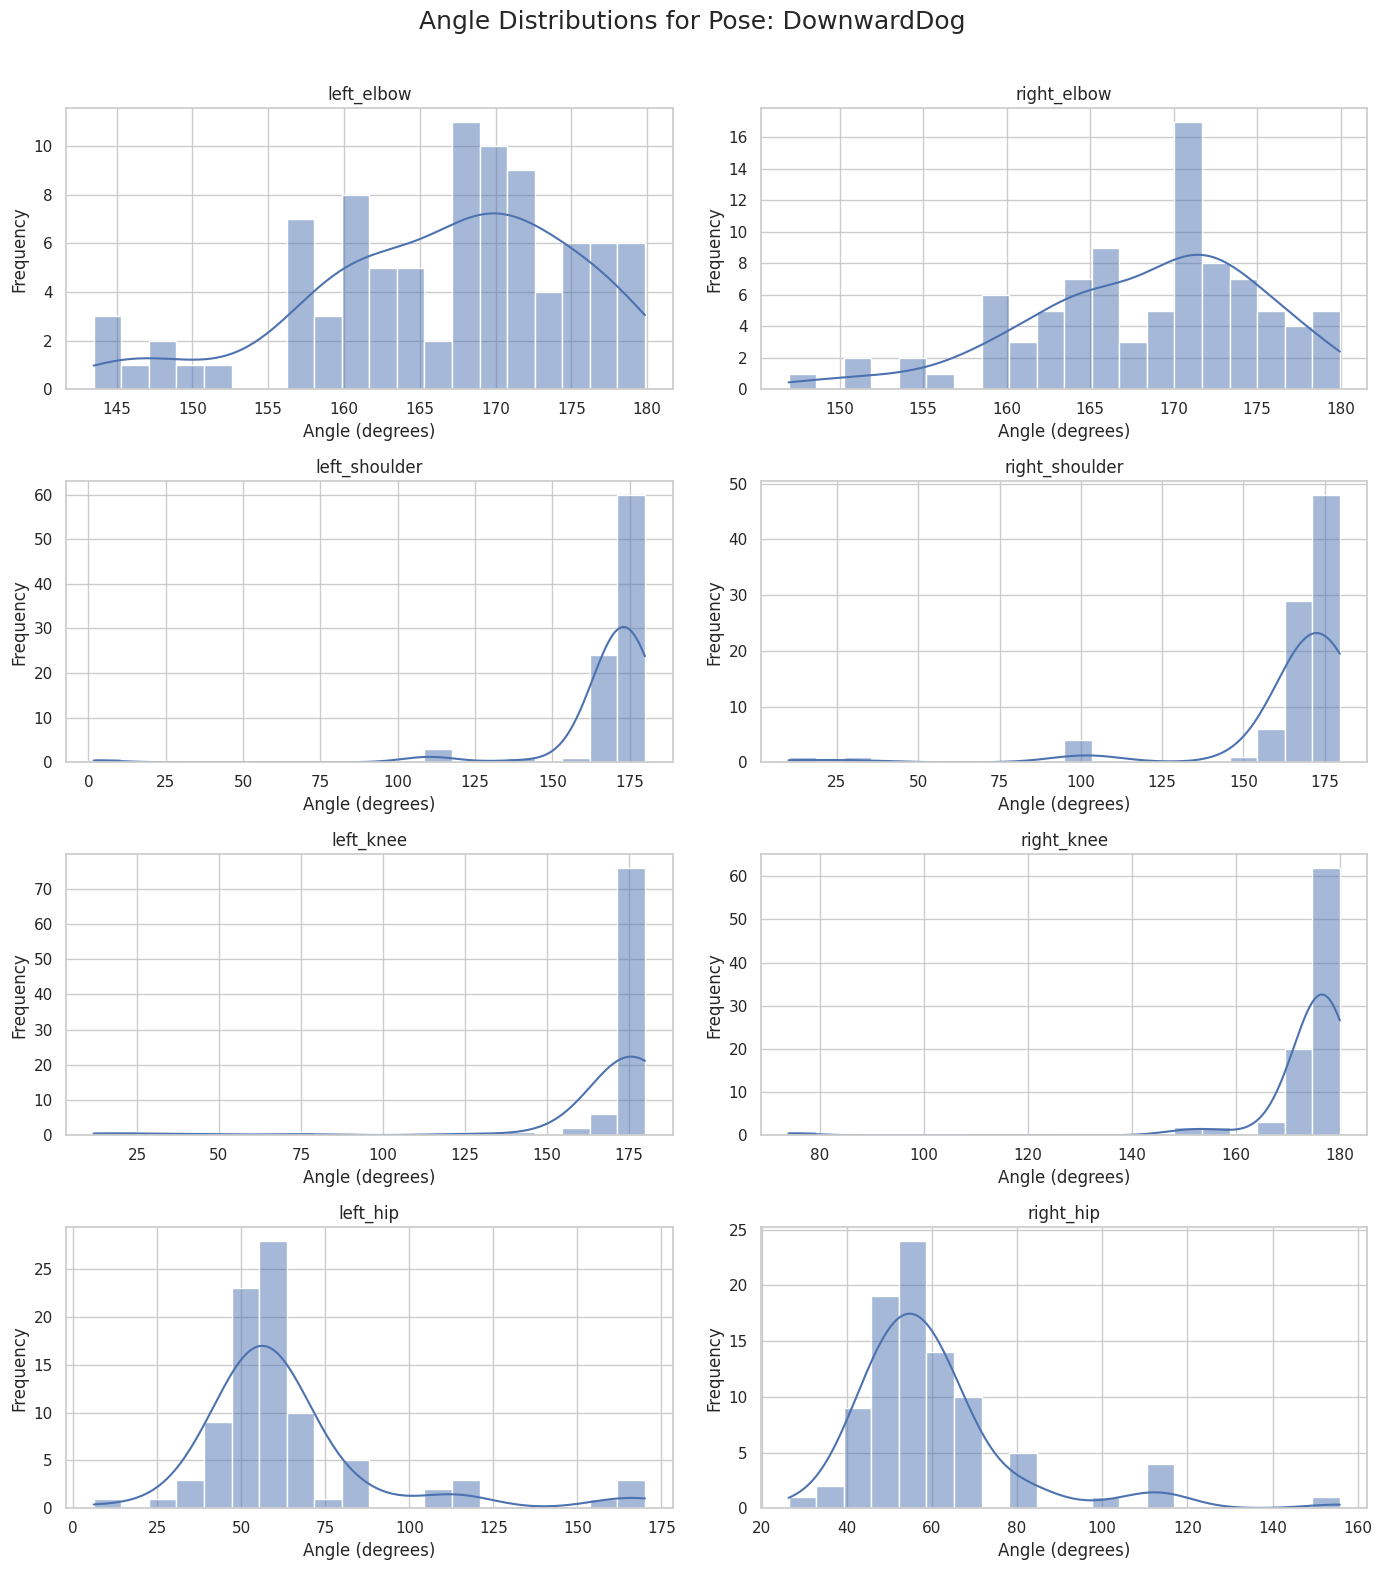


Plotting pose: Plank


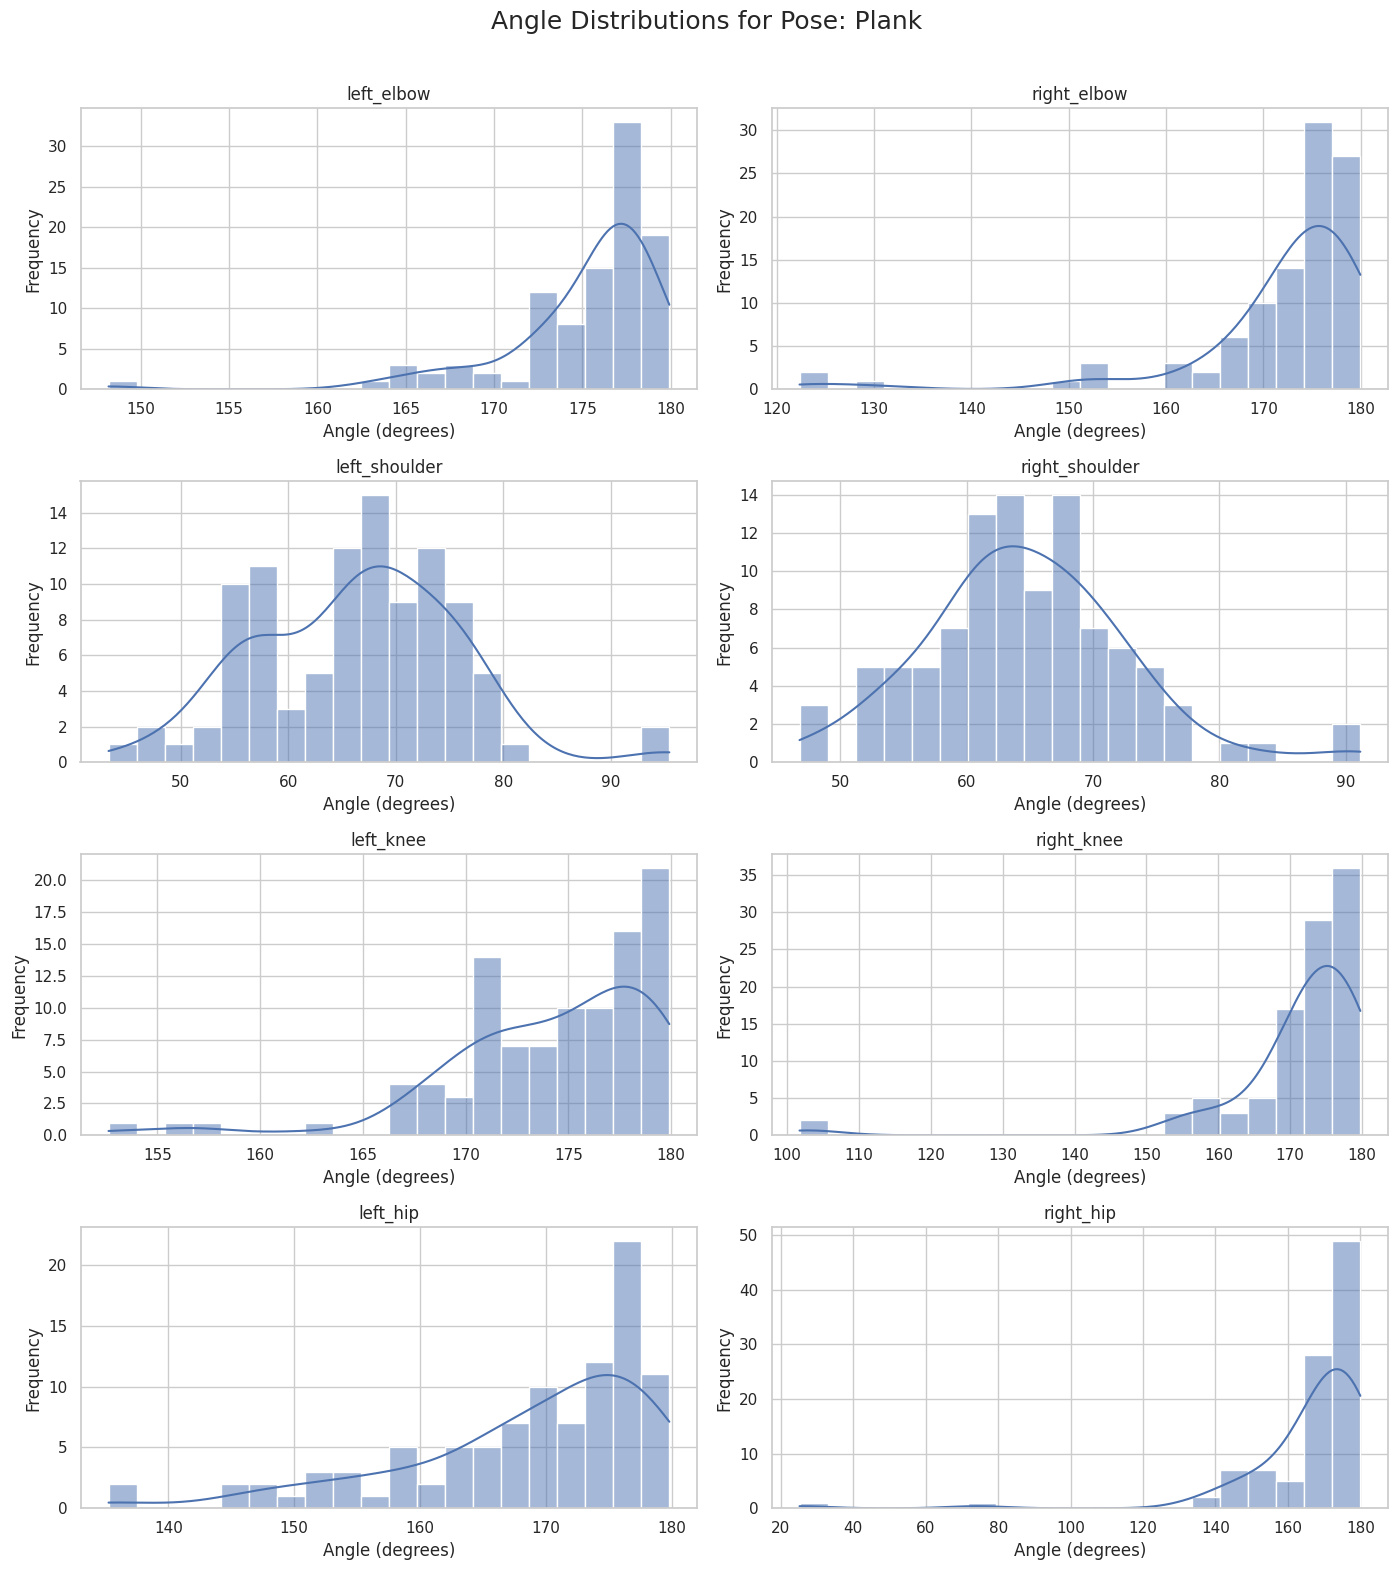


Plotting pose: tree_left


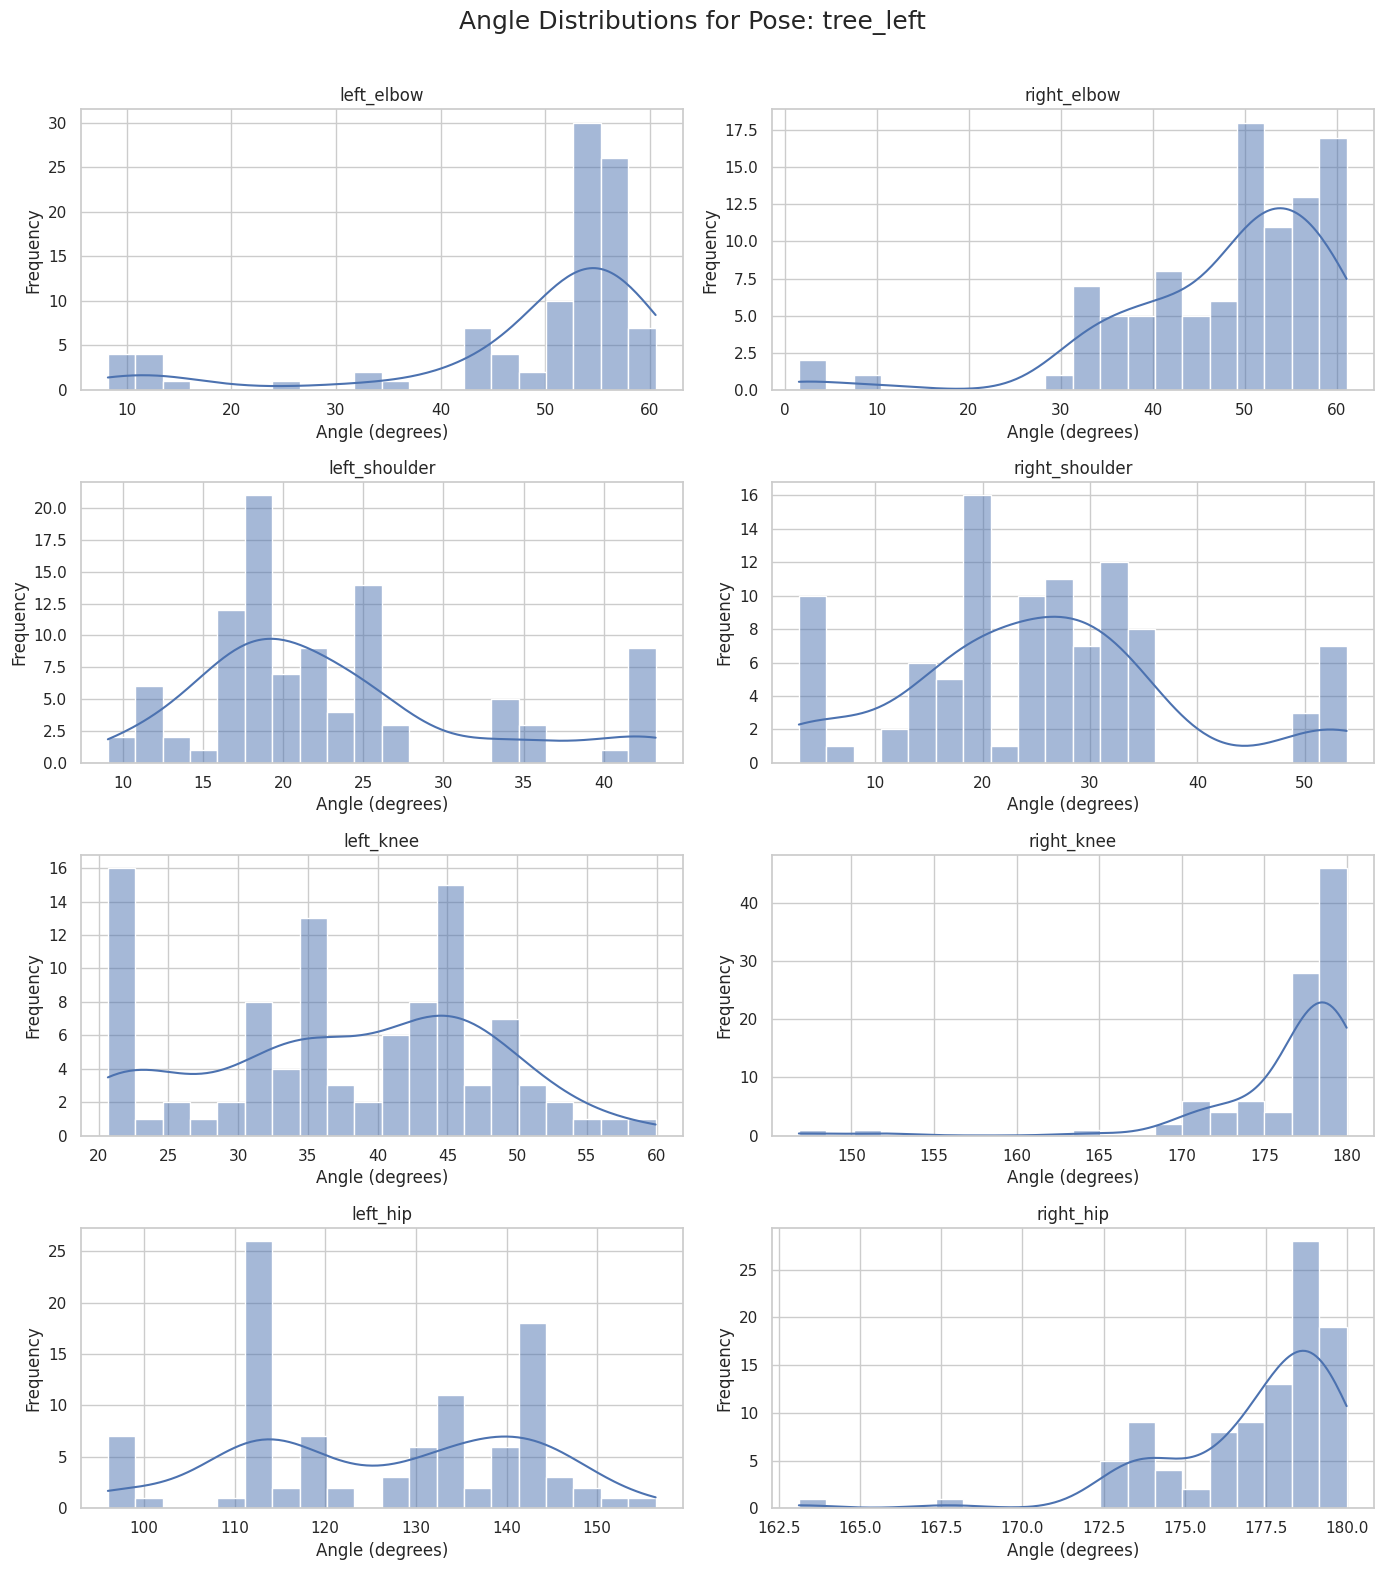


Plotting pose: tree_right


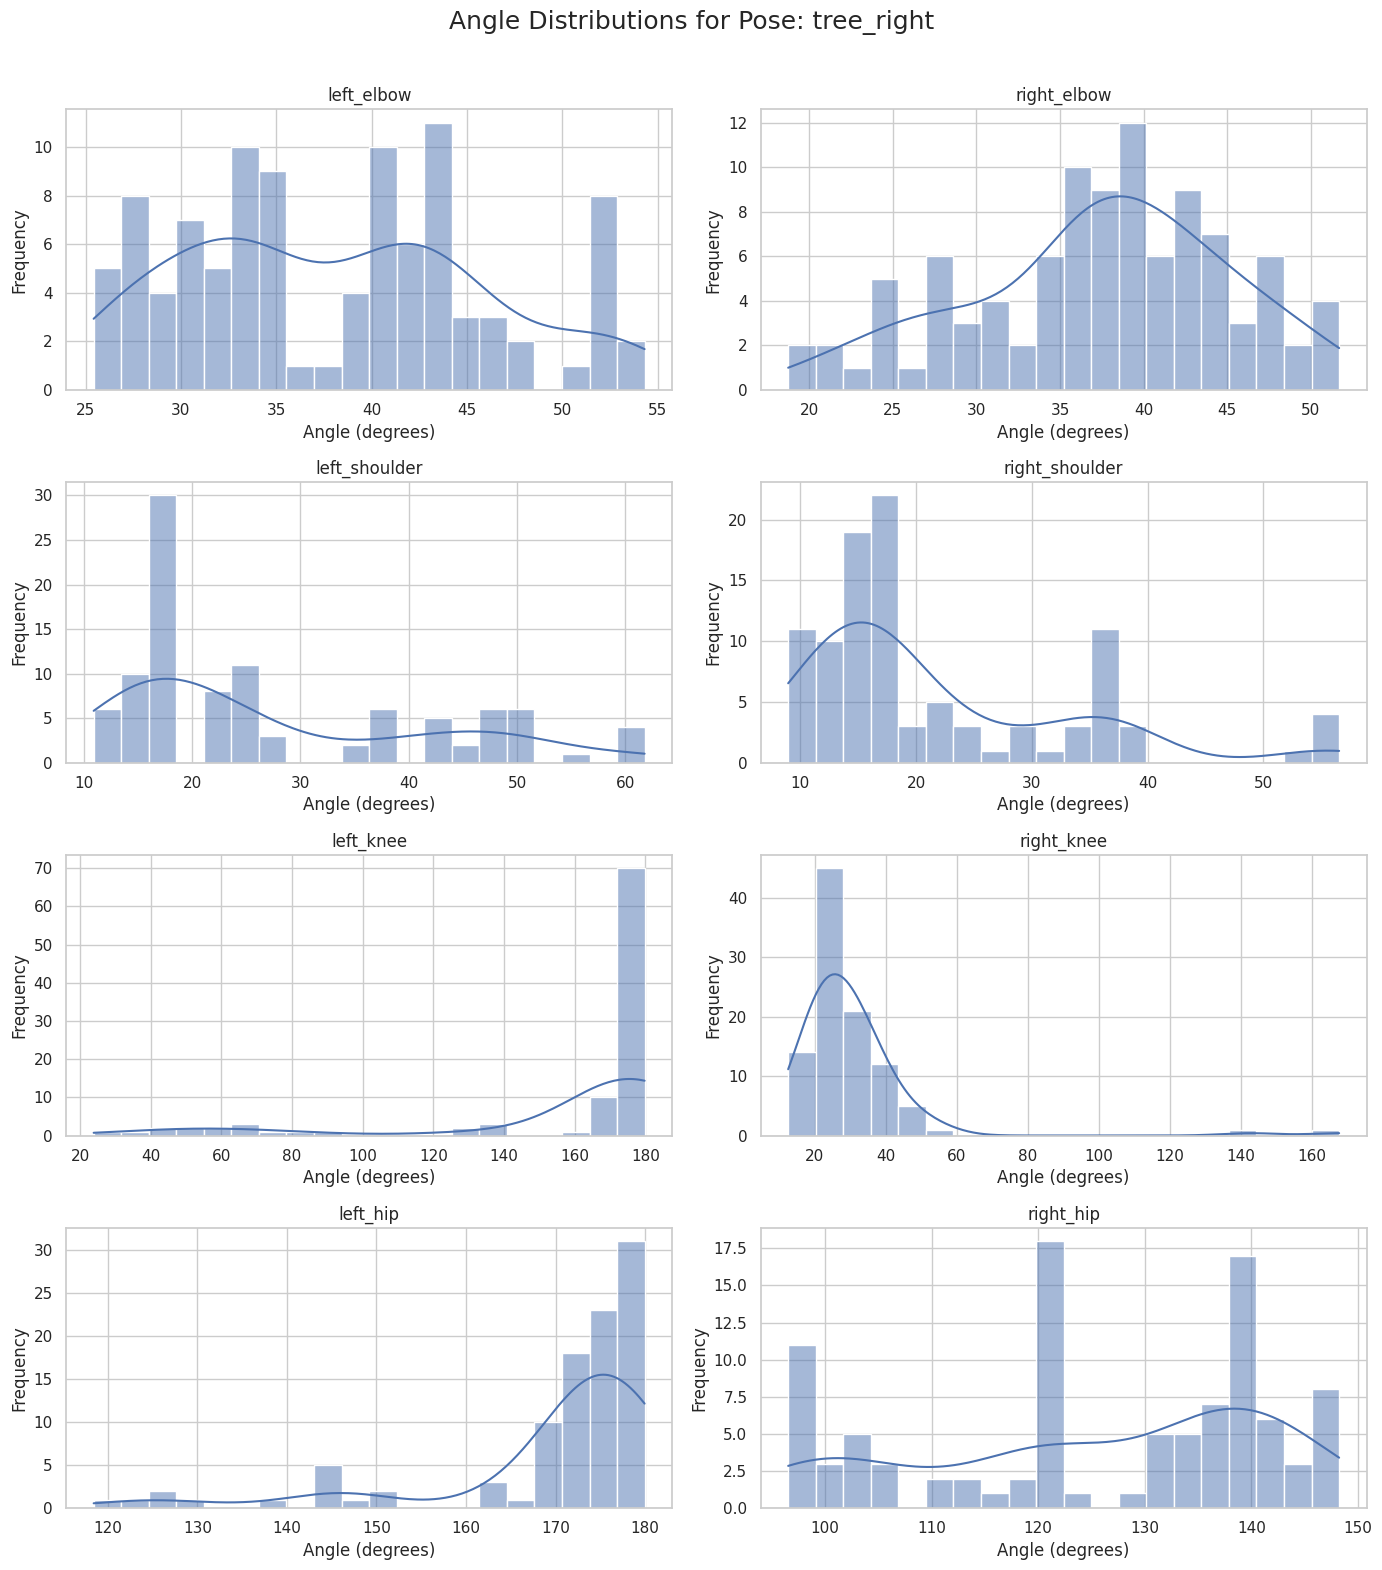


Plotting pose: warrior_left


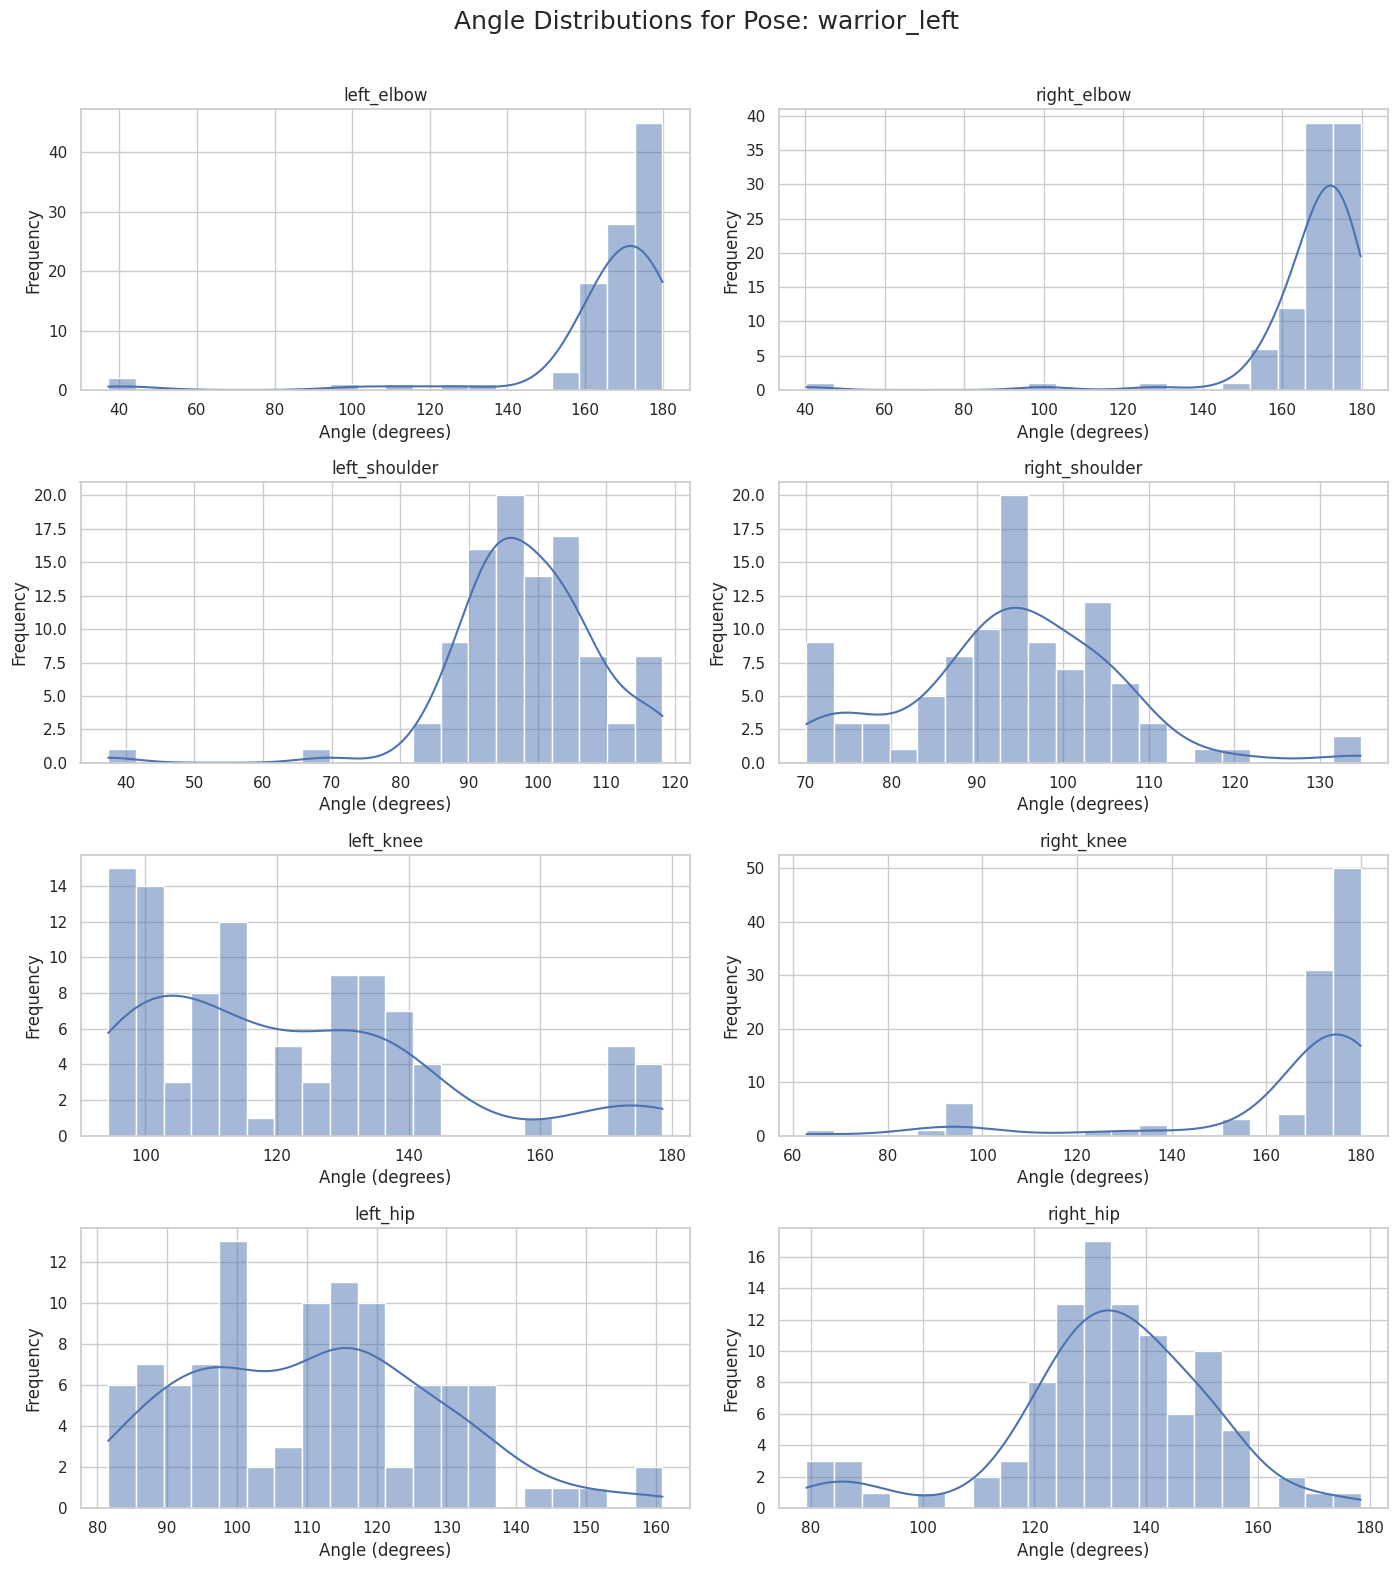


Plotting pose: warrior_right


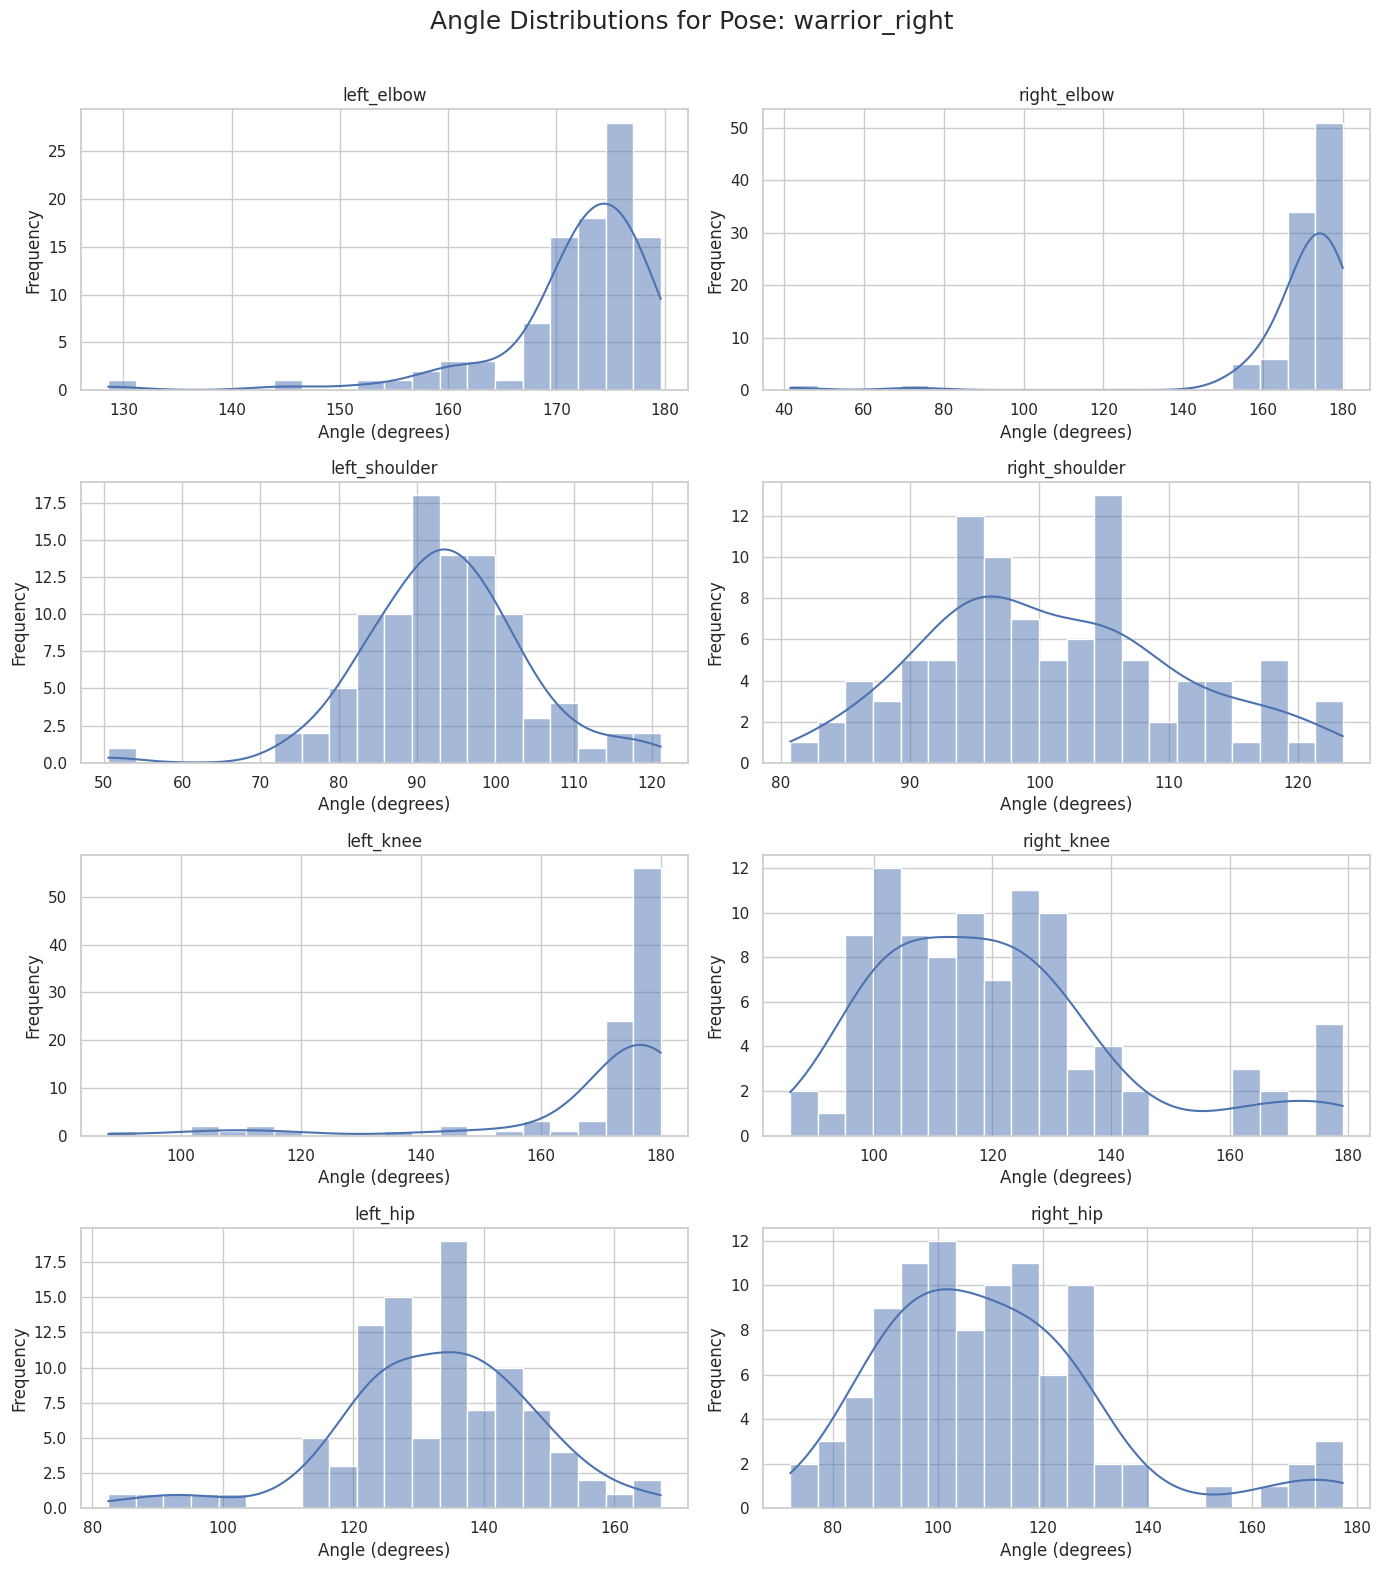


Plotting pose: Goddess


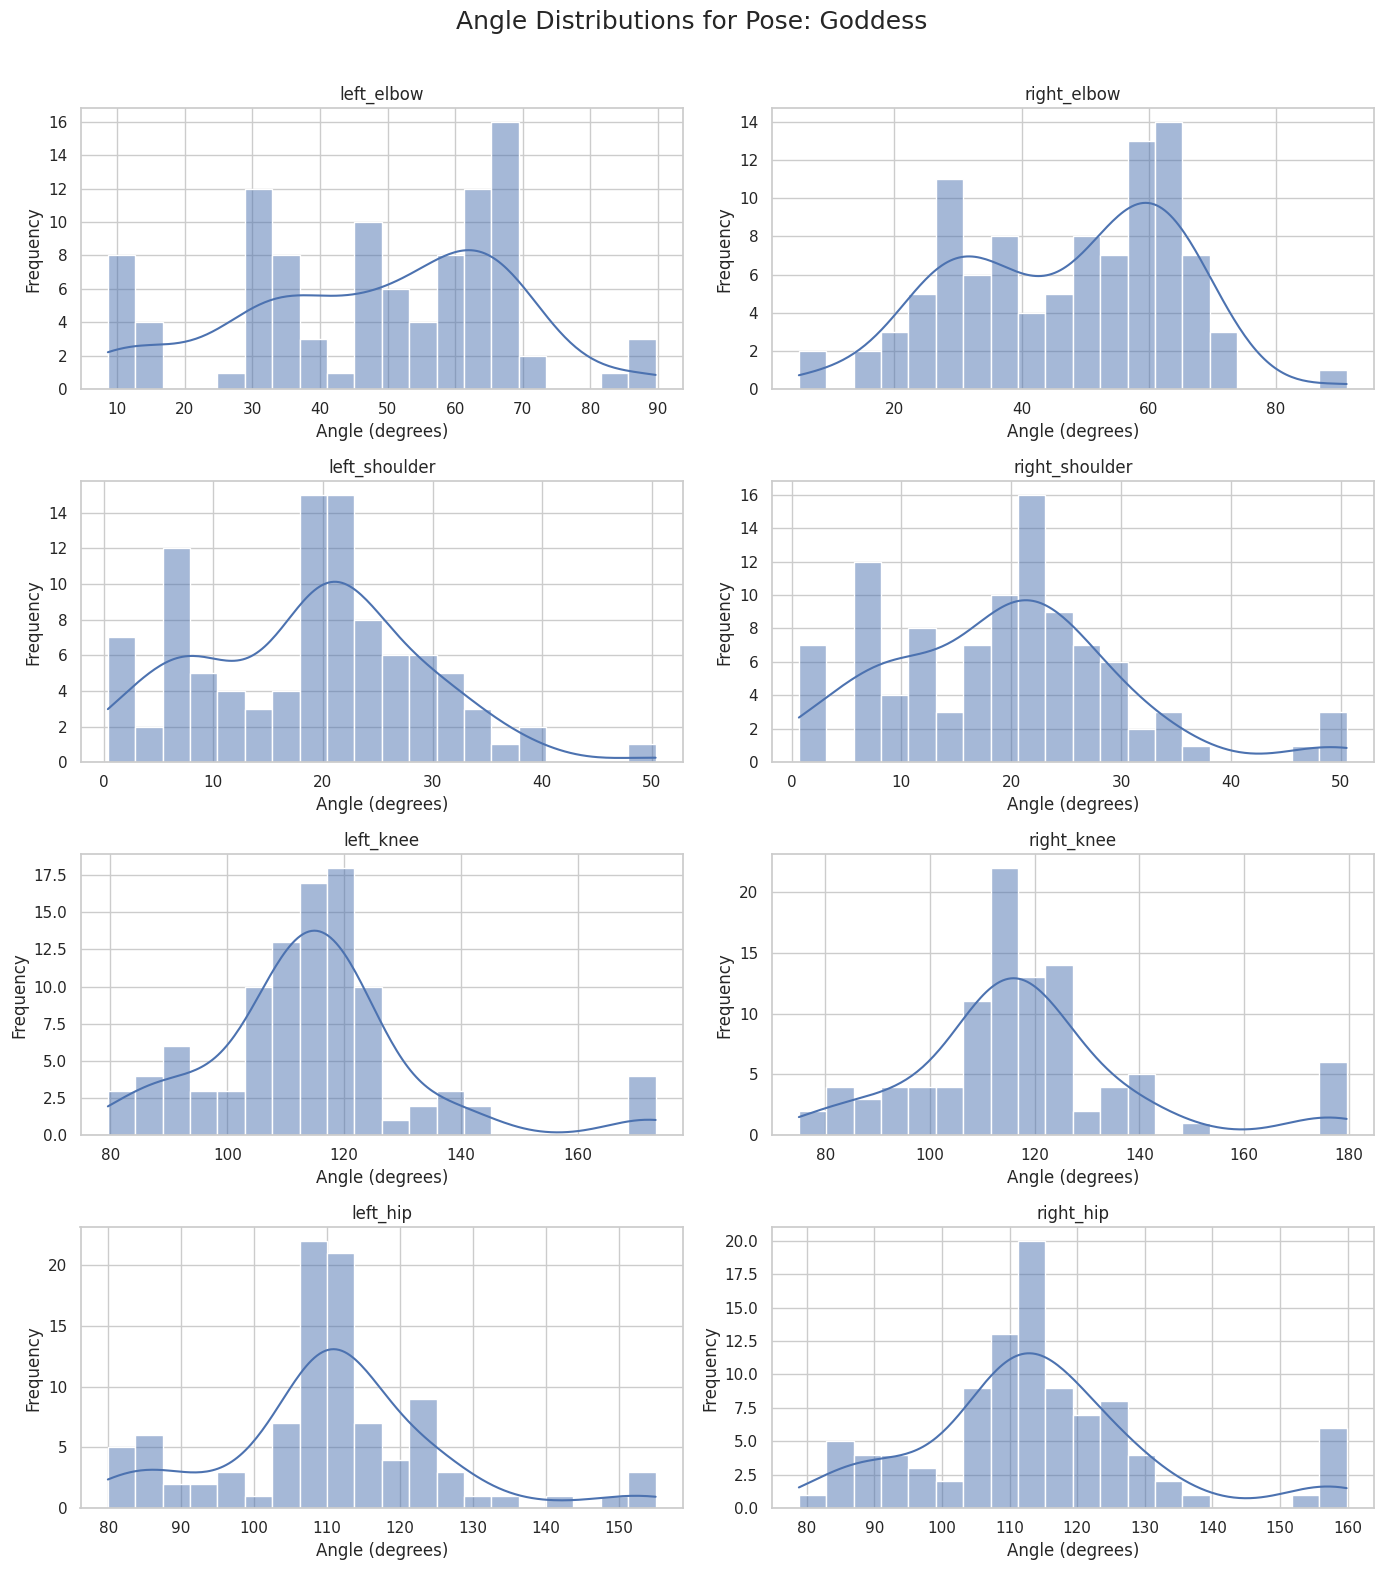

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่า style
sns.set(style="whitegrid")

# วนตามท่า
for pose_name, joints_data in all_angles_raw.items():
    print(f"\nPlotting pose: {pose_name}")

    # สร้าง figure ขนาดใหญ่ 4x2 (8 joints)
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle(f"Angle Distributions for Pose: {pose_name}", fontsize=18)

    axes = axes.flatten()

    # วนตามทุก joint
    for idx, joint in enumerate(joint_names):
        ax = axes[idx]
        angles = joints_data[joint]

        if len(angles) == 0:
            ax.set_title(f"{joint} (no data)")
            ax.set_axis_off()
            continue

        sns.histplot(angles, bins=20, kde=True, ax=ax)
        ax.set_title(joint)
        ax.set_xlabel("Angle (degrees)")
        ax.set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Angle Distribution and Keypoint Percentile Extraction from the Kaggle Dataset
*Used as foundational statistics for establishing rule-based thresholds in Method 2.*

[Kaggle Dataset Link](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset)

In [ ]:
import os
import cv2
import numpy as np
import random

# --- Path root ของ Method1 ---
root_folder = "/content/drive/MyDrive/Kaggle_Method2_Corrrect"
aug_root = "/content/drive/MyDrive/Kaggle_Method2_Corrrect_aug"
os.makedirs(aug_root, exist_ok=True)

# --- ฟังก์ชัน augment (หมุน + brightness) ---
def augment_image(img):
    angle = random.uniform(-15, 15)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h))

    factor = random.uniform(0.9, 1.1)
    img = cv2.convertScaleAbs(img, alpha=factor, beta=0)
    return img

TARGET_NUM = 100

for pose_name in os.listdir(root_folder):
    pose_folder = os.path.join(root_folder, pose_name)
    if not os.path.isdir(pose_folder):
        continue

    aug_folder = os.path.join(aug_root, pose_name)
    os.makedirs(aug_folder, exist_ok=True)

    # --- List รูปทั้งหมดในโฟลเดอร์ (รวม .jpg, .png, .jpeg) ---
    img_files = [f for f in os.listdir(pose_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    if len(img_files) == 0:
        print(f"No images found for {pose_name}, skipping...")
        continue

    # --- คัดลอกรูปเดิม ---
    for f in img_files:
        img = cv2.imread(os.path.join(pose_folder, f))
        if img is not None:
            cv2.imwrite(os.path.join(aug_folder, f), img)

    current_count = len(img_files)

    # --- ทำ augment จนครบ TARGET_NUM ---
    while current_count < TARGET_NUM:
        if len(img_files) == 0:
            print(f"No source images to augment for {pose_name}, stopping.")
            break

        f = random.choice(img_files)
        img = cv2.imread(os.path.join(pose_folder, f))
        if img is None:
            continue
        aug_img = augment_image(img)
        save_name = f"aug_{current_count}_{f}"
        cv2.imwrite(os.path.join(aug_folder, save_name), aug_img)
        current_count += 1

    print(f"{pose_name}: total images = {current_count}")


downdog: total images = 100
plank: total images = 100
goddess: total images = 100
tree_right: total images = 100
tree_left: total images = 100
warrior_left: total images = 100
warrior_right: total images = 100
No images found for .ipynb_checkpoints, skipping...


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from collections import defaultdict
import json

# --- Setup MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

joint_names = ["left_elbow","right_elbow","left_shoulder","right_shoulder",
               "left_knee","right_knee","left_hip","right_hip"]

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def landmarks_to_xy(landmarks, img_width, img_height):
    return [(lm.x * img_width, lm.y * img_height) for lm in landmarks]

def angles_finder(landmarks, img_width, img_height):
    lm = landmarks_to_xy(landmarks, img_width, img_height)

    left_elbow  = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                  lm[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                  lm[mp_pose.PoseLandmark.LEFT_WRIST.value])

    right_elbow = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                  lm[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                  lm[mp_pose.PoseLandmark.RIGHT_WRIST.value])

    left_shoulder = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                    lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    lm[mp_pose.PoseLandmark.LEFT_HIP.value])

    right_shoulder = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     lm[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    left_knee = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_HIP.value],
                                lm[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                lm[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    right_knee = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                 lm[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                 lm[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    left_hip = calculate_angle(lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                               lm[mp_pose.PoseLandmark.LEFT_HIP.value],
                               lm[mp_pose.PoseLandmark.LEFT_KNEE.value])

    right_hip = calculate_angle(lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                lm[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                lm[mp_pose.PoseLandmark.RIGHT_KNEE.value])

    return {
        "left_elbow": left_elbow,
        "right_elbow": right_elbow,
        "left_shoulder": left_shoulder,
        "right_shoulder": right_shoulder,
        "left_knee": left_knee,
        "right_knee": right_knee,
        "left_hip": left_hip,
        "right_hip": right_hip
    }

# --- Path root ของ Method1 Augmented ---
root_folder = "/content/drive/MyDrive/Kaggle_Method2_Corrrect_aug"

# เก็บ angles รวมทุกท่า (ไว้ใช้ดูรวม)
all_angles_jointwise = defaultdict(list)

# เก็บ percentile
all_angles_percentiles = dict()

# ใหม่: เก็บ angles รายท่า → ใช้ plot histogram
all_angles_raw = dict()

# ---------------------------------------------------------
#                  PROCESS EACH POSE
# ---------------------------------------------------------
for pose_name in os.listdir(root_folder):
    pose_folder = os.path.join(root_folder, pose_name)
    if not os.path.isdir(pose_folder):
        continue

    print(f"\nProcessing pose: {pose_name}")

    # เก็บ angles ของท่านี้
    angles_all = defaultdict(list)
    all_angles_raw[pose_name] = defaultdict(list)

    for img_file in os.listdir(pose_folder):
        if not img_file.lower().endswith((".jpg", ".png")):
            continue
        img_path = os.path.join(pose_folder, img_file)

        try:
            img = cv2.imread(img_path)
            if img is None:
                continue

            results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if results.pose_landmarks:
                angles = angles_finder(results.pose_landmarks.landmark, img.shape[1], img.shape[0])

                # เก็บค่าของทุก joint
                for joint in joint_names:
                    angle_value = angles[joint]
                    angles_all[joint].append(angle_value)
                    all_angles_jointwise[joint].append(angle_value)
                    all_angles_raw[pose_name][joint].append(angle_value)

        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

    # --- คำนวณ percentile 5 และ 95 ---
    pose_percentiles = dict()
    for joint, angles in angles_all.items():
        if len(angles) == 0:
            continue

        angles_array = np.array(angles)
        p5 = float(np.percentile(angles_array, 5))
        p95 = float(np.percentile(angles_array, 95))

        pose_percentiles[joint] = {"p5": p5, "p95": p95}

    all_angles_percentiles[pose_name] = pose_percentiles

# ---------------------------------------------------------
#                  SAVE JSON OUTPUT
# ---------------------------------------------------------
output_path = os.path.join(root_folder, "pose_keypoints_percentiles.json")
with open(output_path, "w") as f:
    json.dump(all_angles_percentiles, f, indent=4)

print(f"\nPercentiles saved to {output_path}")
print("Raw angle data stored in all_angles_raw (for histogram plotting)")


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(



Processing pose: downdog

Processing pose: plank

Processing pose: goddess

Processing pose: tree_right

Processing pose: tree_left

Processing pose: warrior_left

Processing pose: warrior_right

Percentiles saved to /content/drive/MyDrive/Kaggle_Method2_Corrrect_aug/pose_keypoints_percentiles.json
Raw angle data stored in all_angles_raw (for histogram plotting)



Plotting pose: downdog


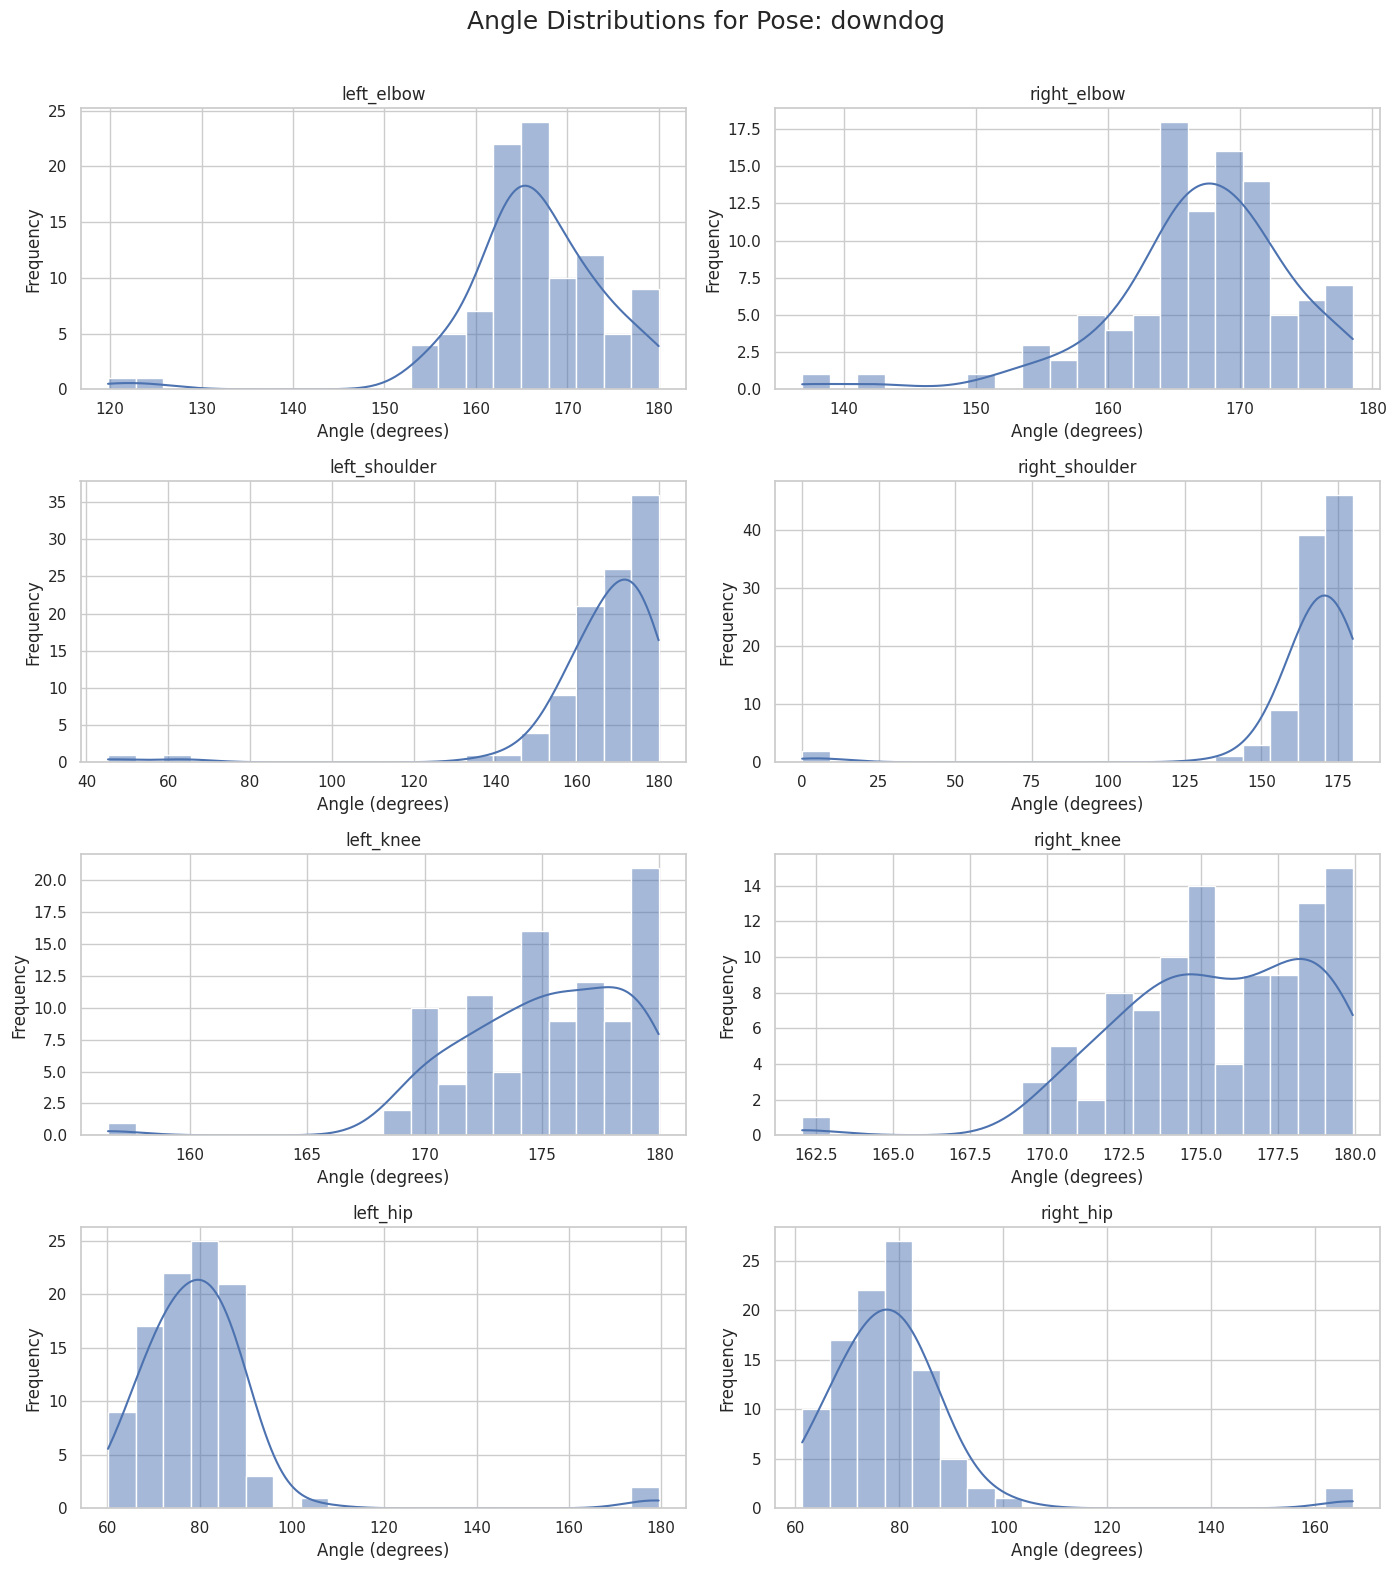


Plotting pose: plank


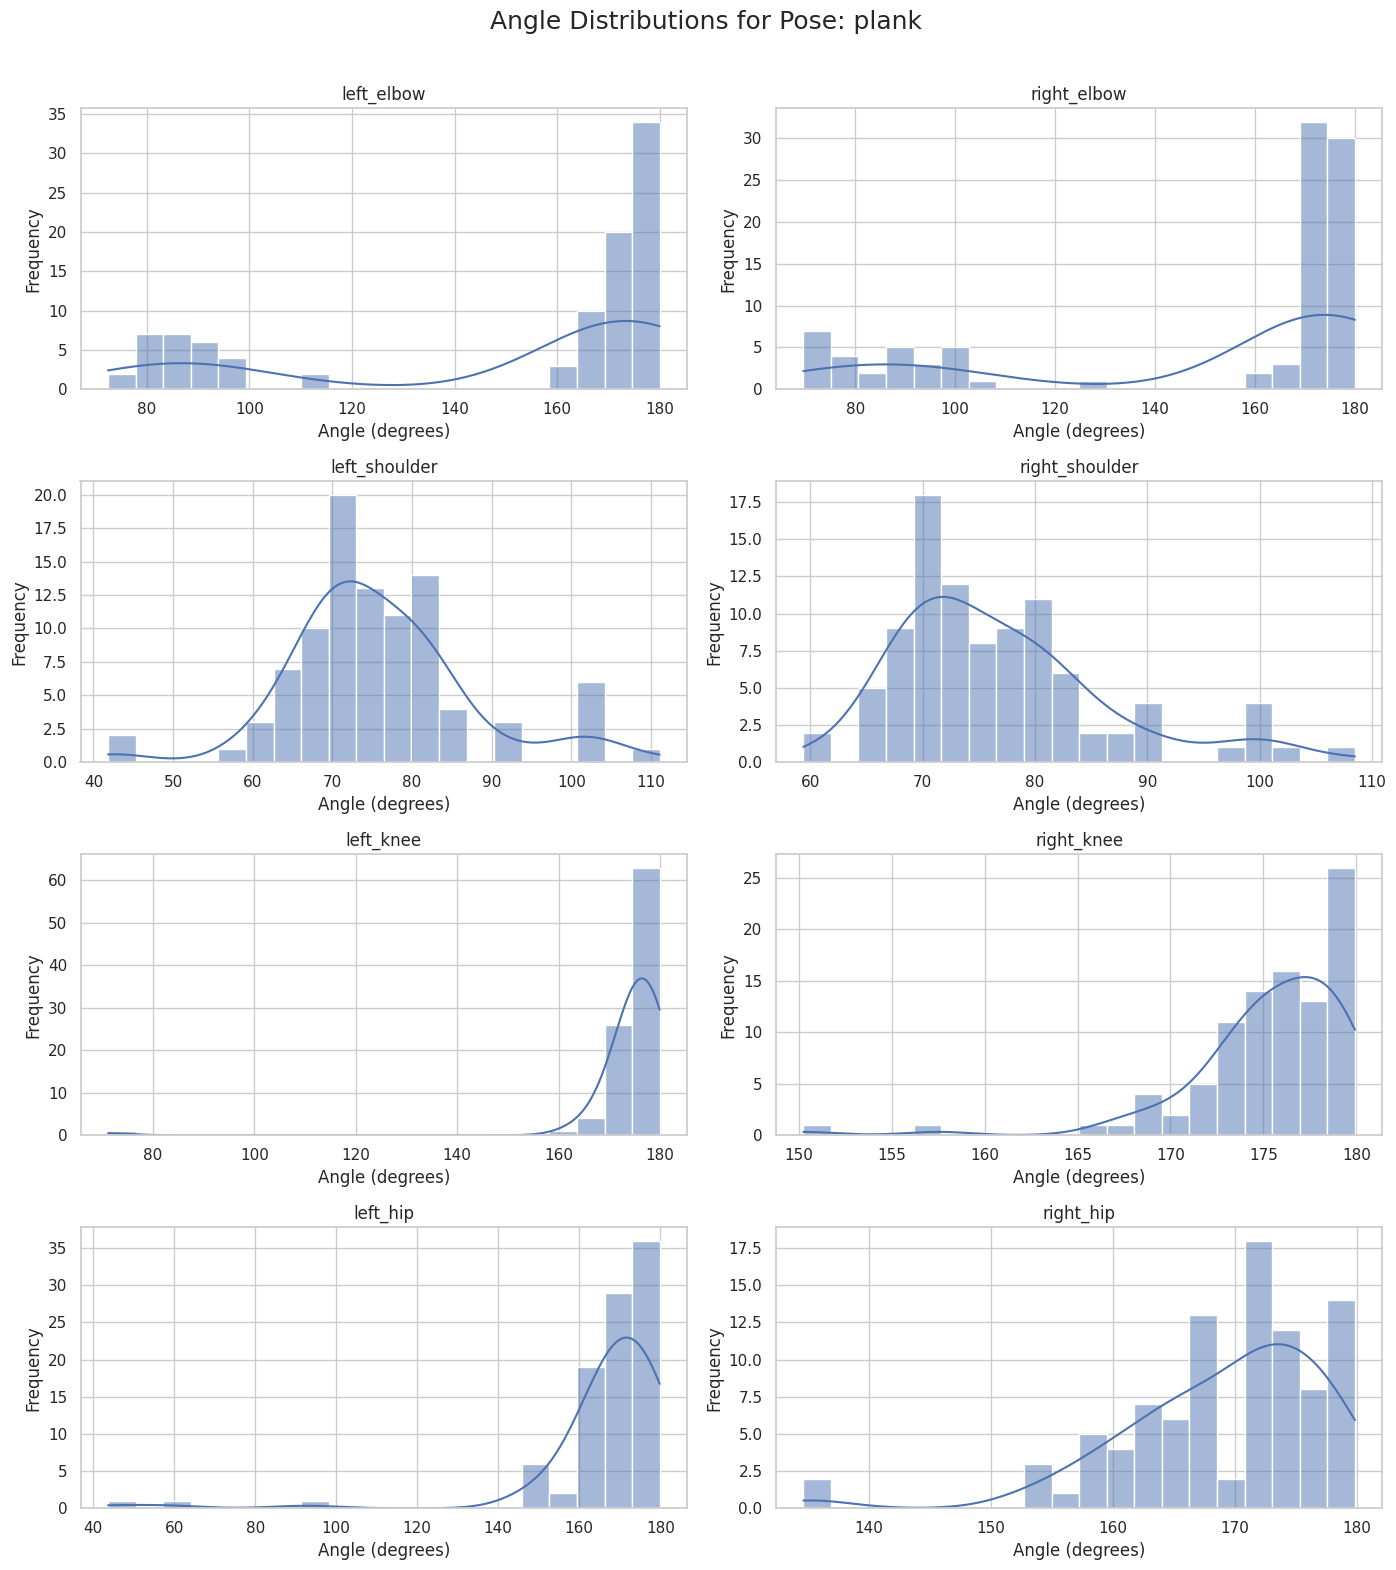


Plotting pose: goddess


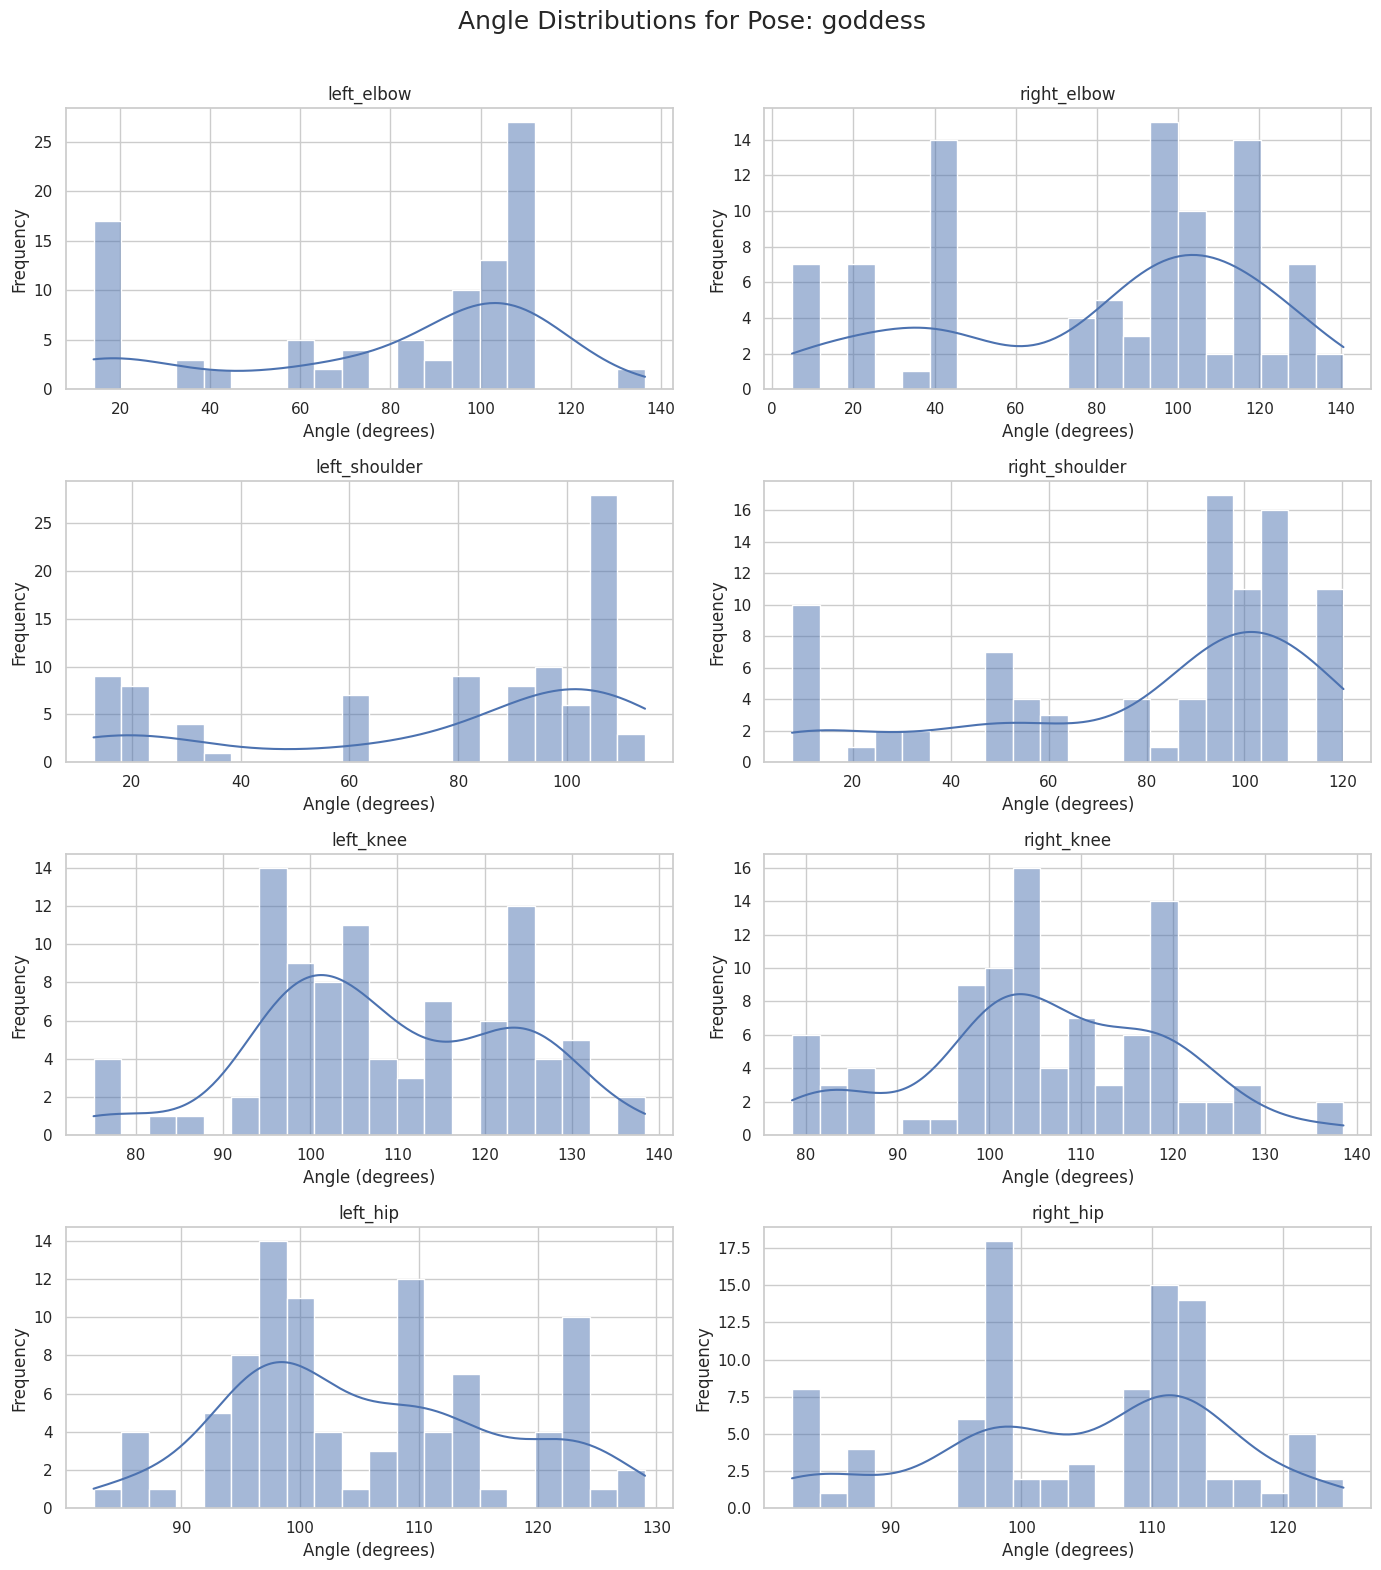


Plotting pose: tree_right


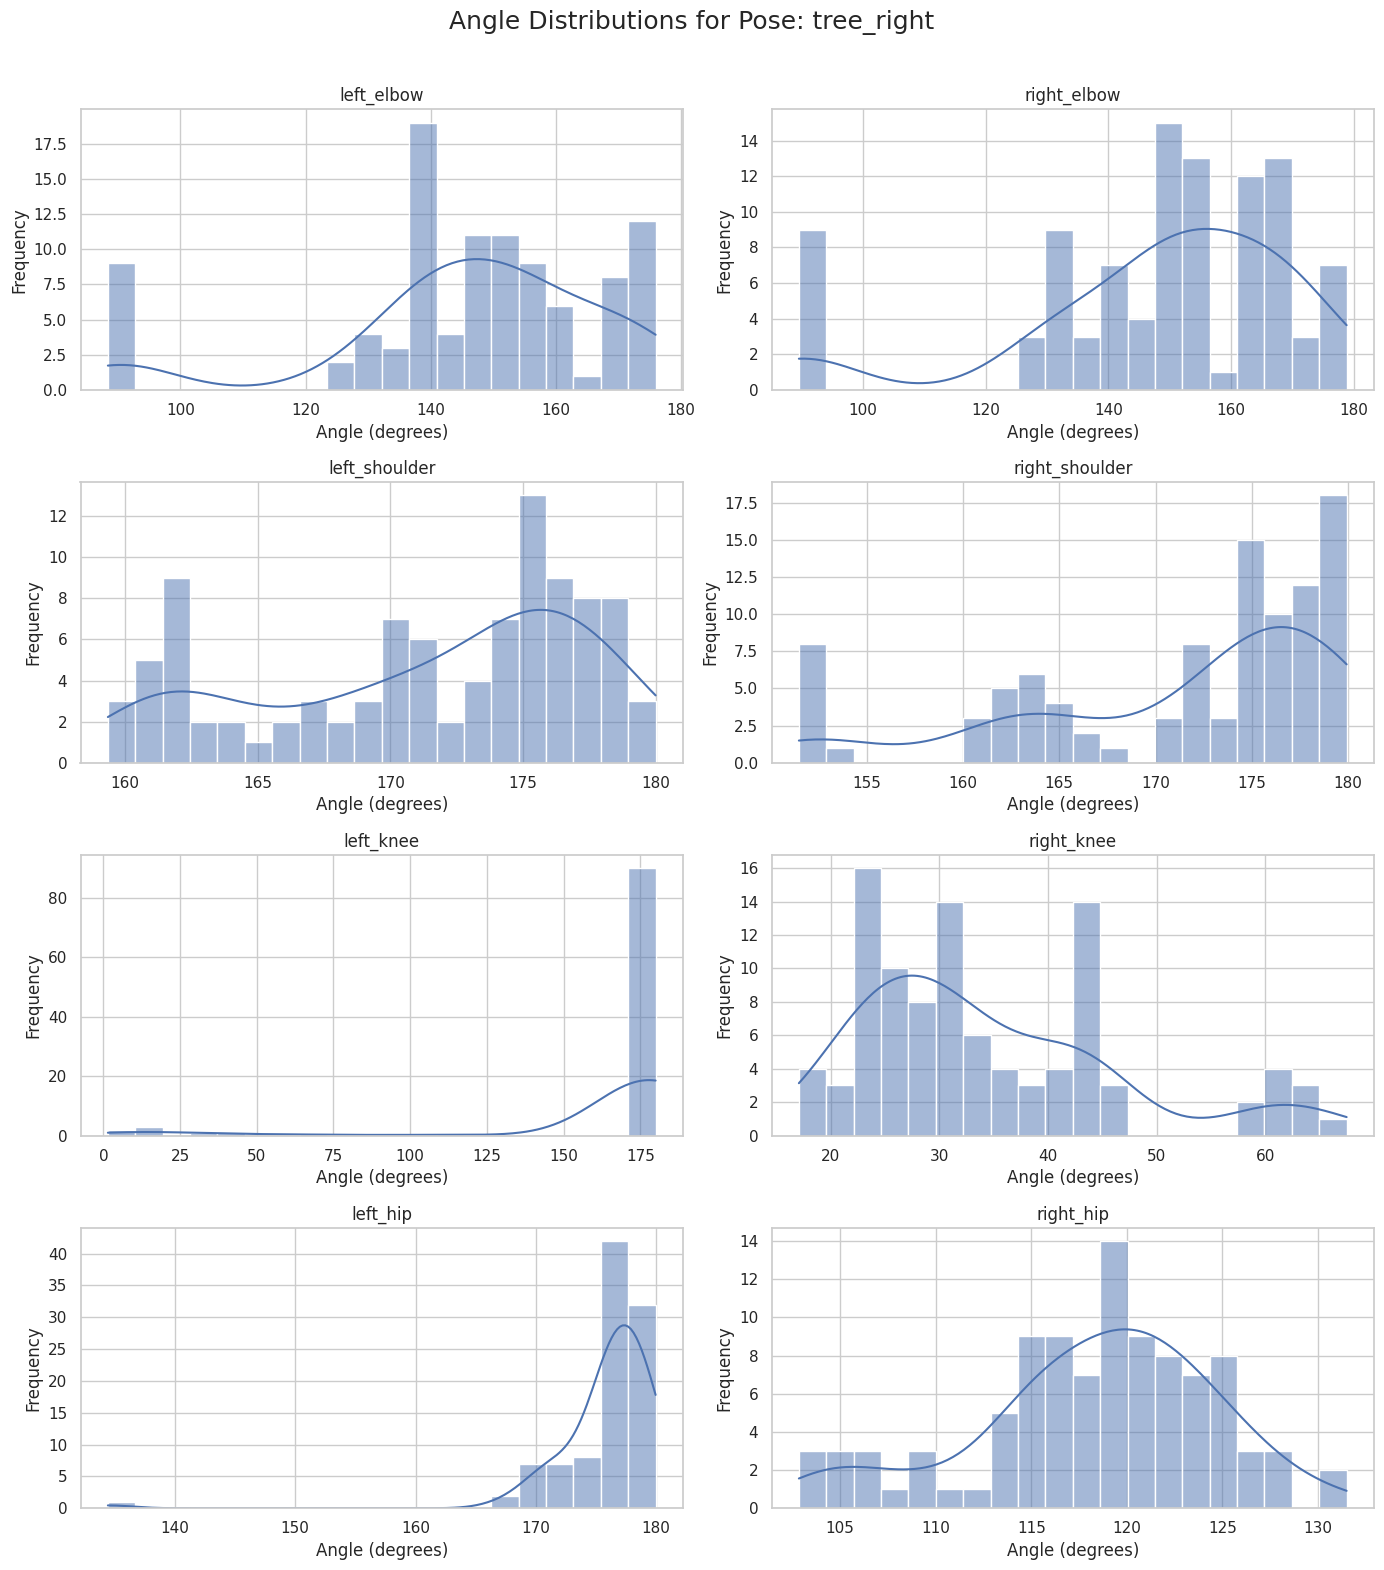


Plotting pose: tree_left


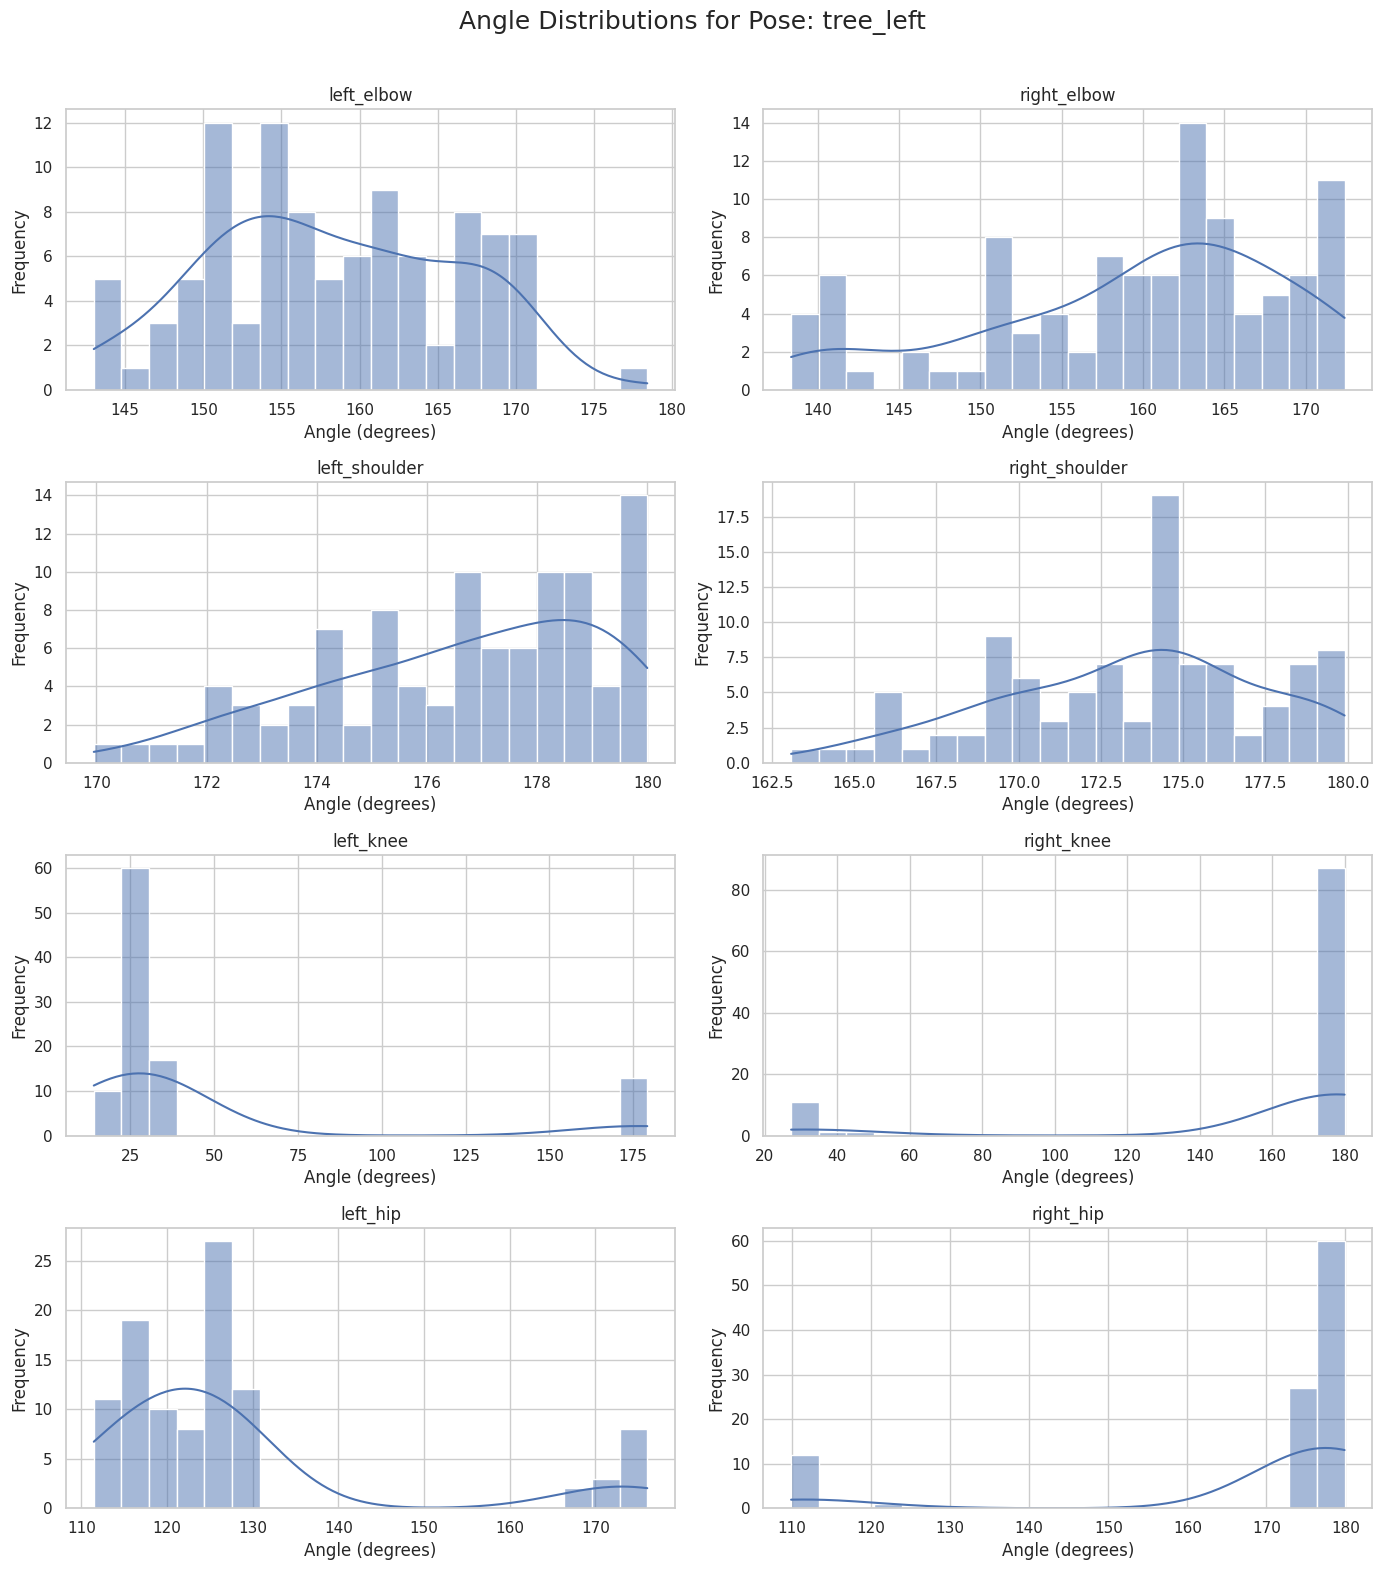


Plotting pose: warrior_left


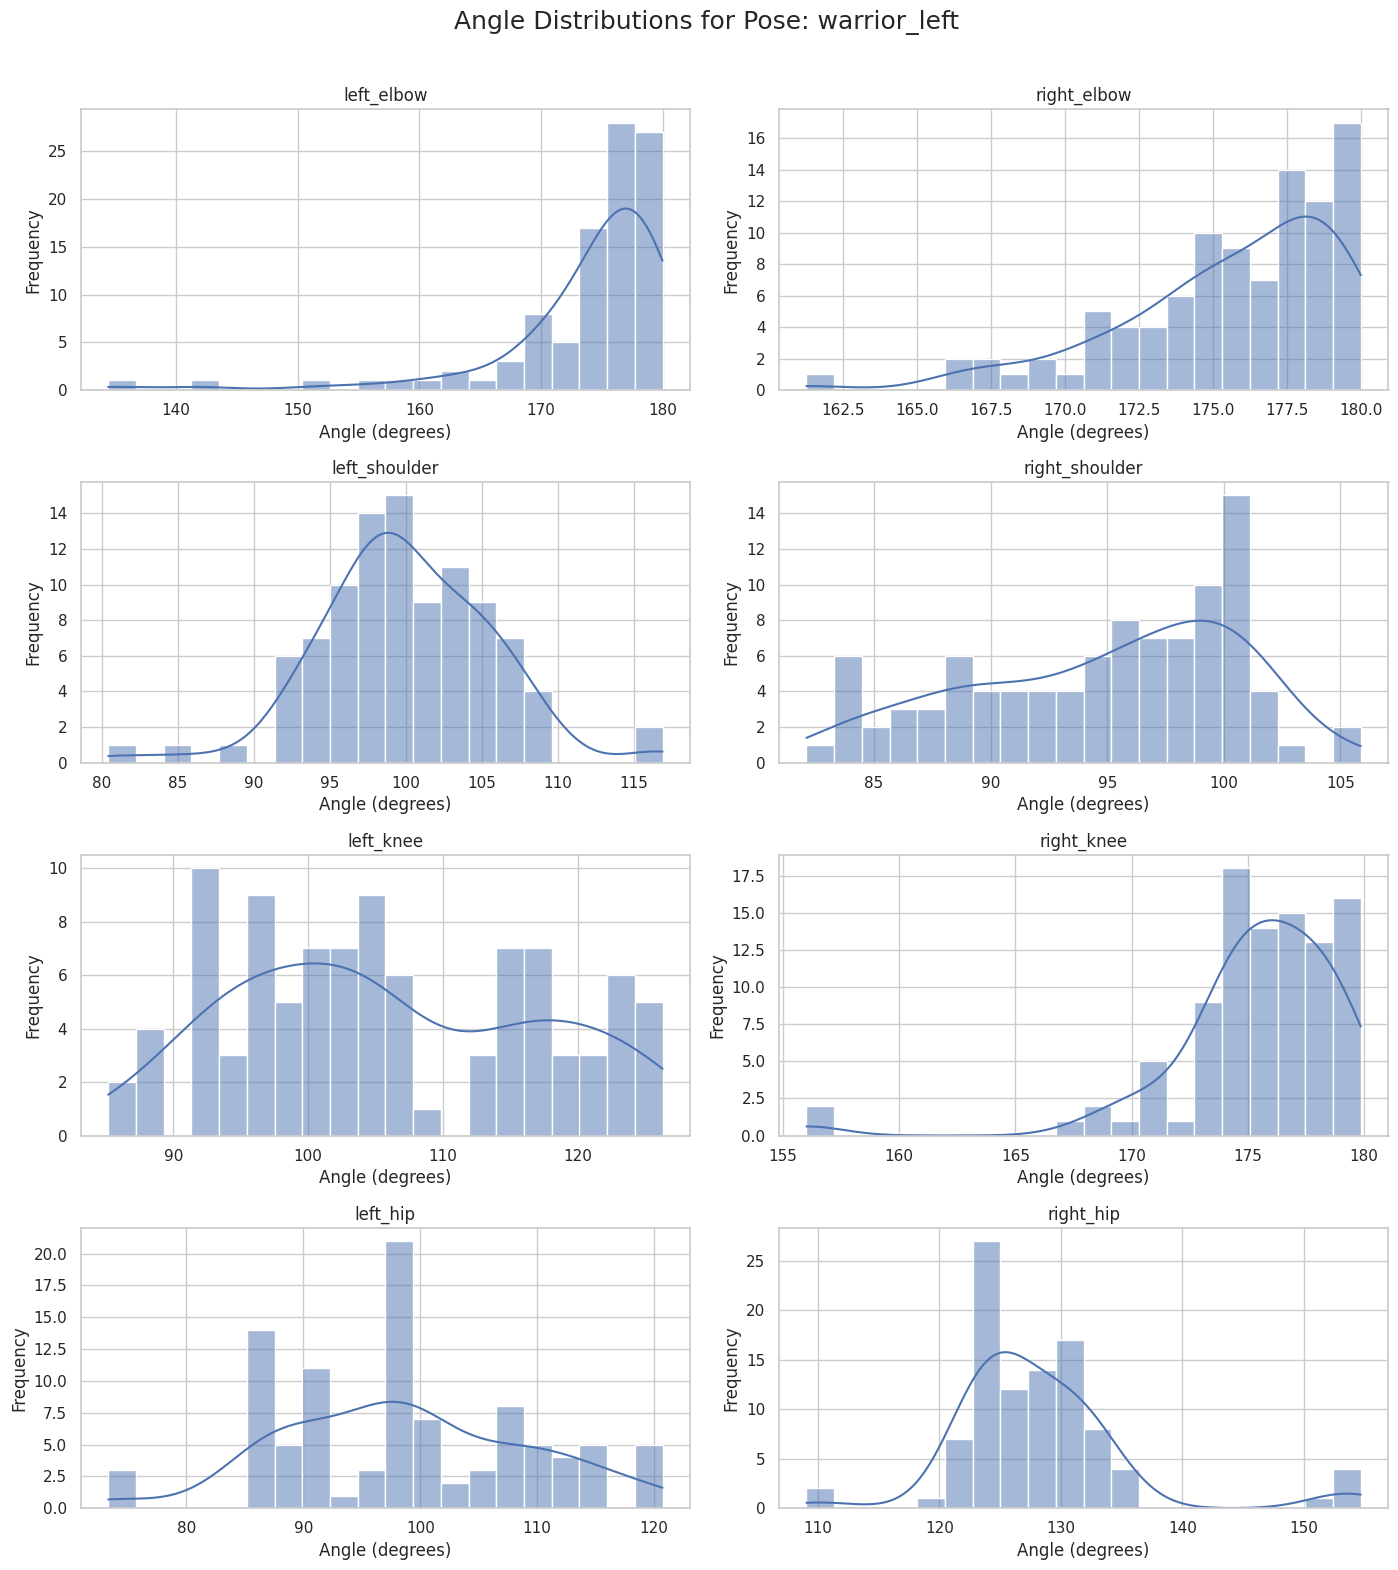


Plotting pose: warrior_right


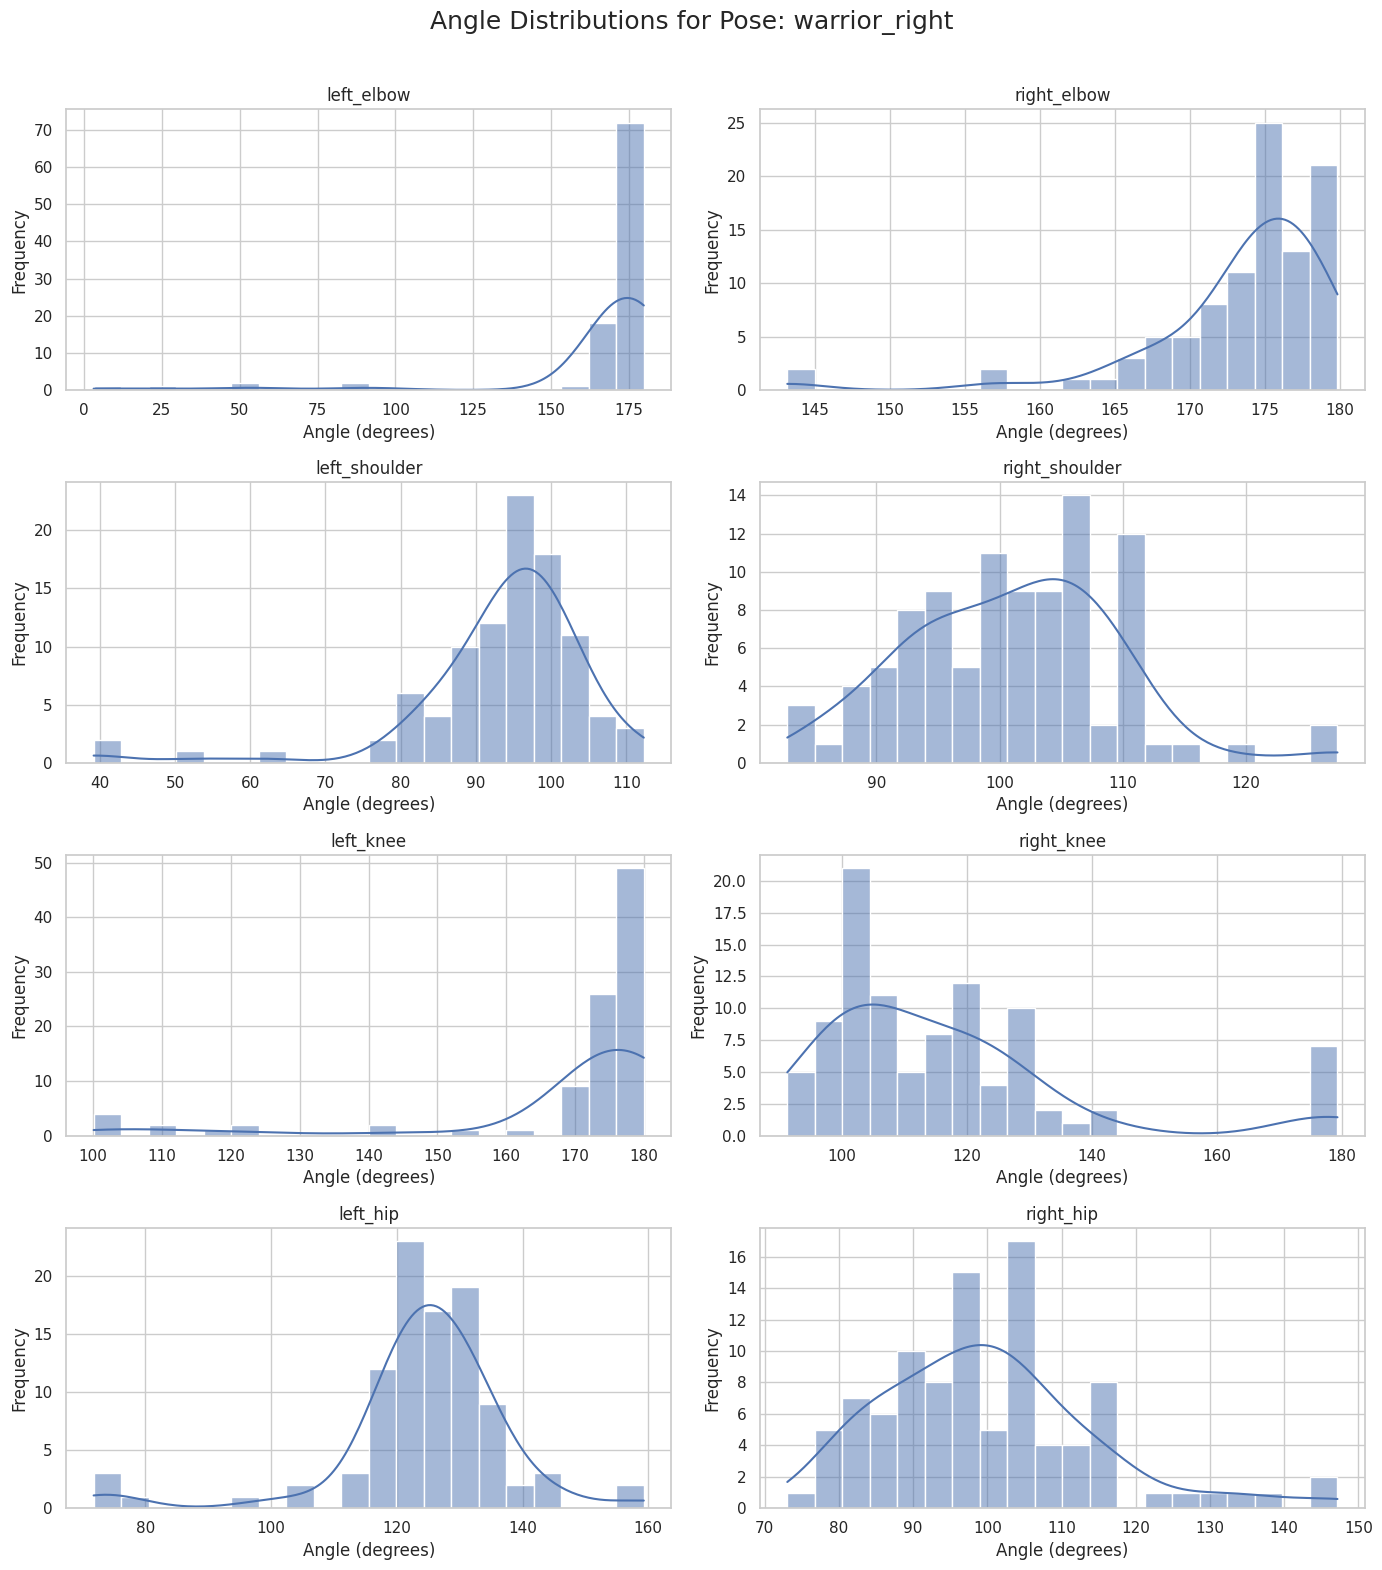

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่า style
sns.set(style="whitegrid")

# วนตามท่า
for pose_name, joints_data in all_angles_raw.items():
    print(f"\nPlotting pose: {pose_name}")

    # สร้าง figure ขนาดใหญ่ 4x2 (8 joints)
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle(f"Angle Distributions for Pose: {pose_name}", fontsize=18)

    axes = axes.flatten()

    # วนตามทุก joint
    for idx, joint in enumerate(joint_names):
        ax = axes[idx]
        angles = joints_data[joint]

        if len(angles) == 0:
            ax.set_title(f"{joint} (no data)")
            ax.set_axis_off()
            continue

        sns.histplot(angles, bins=20, kde=True, ax=ax)
        ax.set_title(joint)
        ax.set_xlabel("Angle (degrees)")
        ax.set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Result from Roboflow Dataset (Method 1)

In [ ]:
import json
import pandas as pd

json_path = "/content/drive/MyDrive/Roboflow_Method1_Correct_aug/pose_keypoints_percentiles.json"

# --- โหลด JSON ---
with open(json_path, "r") as f:
    data = json.load(f)

# --- แปลงเป็น DataFrame ---
rows = []
for pose_name, joints in data.items():
    for joint_name, percentiles in joints.items():
        rows.append({
            "Pose": pose_name,
            "Joint": joint_name,
            "P5": percentiles["p5"],
            "P95": percentiles["p95"]
        })

df = pd.DataFrame(rows)
df = df.sort_values(by=["Pose", "Joint"]).reset_index(drop=True)
df


,Pose,Joint,P5,P95
0,DownwardDog,left_elbow,147.832436,178.465670
1,DownwardDog,left_hip,38.800612,114.945961
2,DownwardDog,left_knee,133.460353,179.448398
3,DownwardDog,left_shoulder,149.730980,179.141497
4,DownwardDog,right_elbow,155.645217,178.103815
5,DownwardDog,right_hip,42.135056,107.656570
6,DownwardDog,right_knee,161.555957,179.366464
7,DownwardDog,right_shoulder,102.606233,179.186795
8,Goddess,left_elbow,11.779970,69.790477
9,Goddess,left_hip,83.932414,134.606324


# Result from Kaggle Dataset (Method 2)

In [ ]:
import json
import pandas as pd

json_path = "/content/drive/MyDrive/Kaggle_Method2_Corrrect_aug/pose_keypoints_percentiles.json"

# --- โหลด JSON ---
with open(json_path, "r") as f:
    data = json.load(f)

# --- แปลงเป็น DataFrame ---
rows = []
for pose_name, joints in data.items():
    for joint_name, percentiles in joints.items():
        rows.append({
            "Pose": pose_name,
            "Joint": joint_name,
            "P5": percentiles["p5"],
            "P95": percentiles["p95"]
        })

df = pd.DataFrame(rows)
df = df.sort_values(by=["Pose", "Joint"]).reset_index(drop=True)
df


,Pose,Joint,P5,P95
0,downdog,left_elbow,155.629599,178.656514
1,downdog,left_hip,64.181802,90.410639
2,downdog,left_knee,169.666224,179.574701
3,downdog,left_shoulder,151.720959,177.734644
4,downdog,right_elbow,154.797499,177.835991
5,downdog,right_hip,62.959955,91.750634
6,downdog,right_knee,170.628399,179.684988
7,downdog,right_shoulder,152.812539,179.490046
8,goddess,left_elbow,15.128618,111.254518
9,goddess,left_hip,87.172297,123.906127
